# Домашнє завдання: "Аналіз часових рядів"

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

Необхідні імпорти:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import acf
from scipy.stats import boxcox

from rich.console import Console
from rich.table import Table

In [ ]:
import warnings
warnings.simplefilter("ignore")

## Завдання 1

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
file_name = '/content/drive/MyDrive/ML/data/time_series/train.csv.zip'
df = pd.read_csv(file_name, parse_dates=["date"])

In [ ]:
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [ ]:
df.set_index("date", inplace=True)
df.head(10)

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


Окремий датафрейм з агрегайцією по місяцю:

In [ ]:
df_monthly = df.copy()
df_monthly['month'] = df_monthly.index.to_period('M')

## Завдання 2

  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



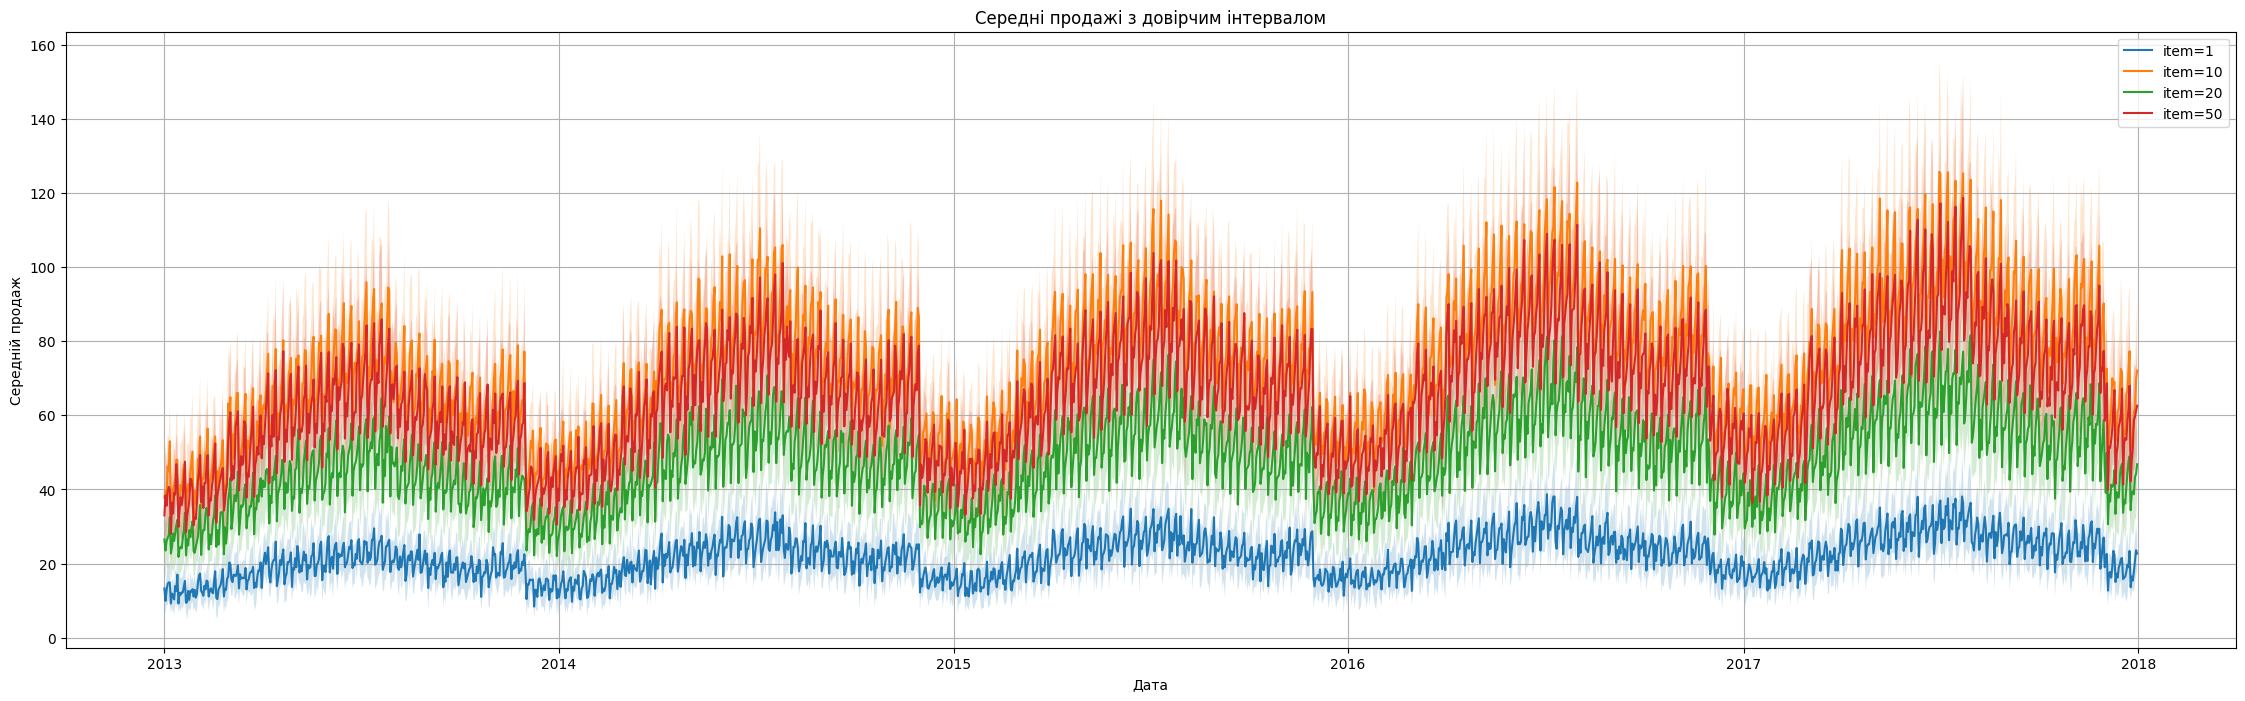

In [ ]:
df_grouped = df.groupby(["date", "item"])["sales"].agg(["mean", "std"]).reset_index()
df_grouped["lower"] = df_grouped["mean"] - df_grouped["std"]
df_grouped["upper"] = df_grouped["mean"] + df_grouped["std"]

plt.figure(figsize=(28, 8))
selected_items = [1, 10, 20, 50]

for item in selected_items:
    subset = df_grouped[df_grouped["item"] == item]
    plt.plot(subset["date"], subset["mean"], label=f"item={item}")
    plt.fill_between(subset["date"], subset["lower"], subset["upper"], alpha=0.2)

plt.title("Середні продажі з довірчим інтервалом")
plt.xlabel("Дата")
plt.ylabel("Середній продаж")
plt.legend()
plt.grid(True)
plt.show()


**Спостереження**:

- На графіку чітко видно сезонні коливання продажів, з піками та спадами, що повторюються щороку.

- Товари мають різні рівні середніх продажів, можливо у них різна цільова аудиторія.

- Усі товари показують схожі сезонні коливання, але амплітуда цих коливань може відрізнятися.

- Деякі товари можуть мати більш виражені піки продажів у певні періоди року.

- Ширина довірчих інтервалів може відрізнятися для різних товарів, що свідчить про різну мінливість продажів.


Для більш простої візууальної оцінки можемо подивитись на візуалізацію з агрегацією по місяцю

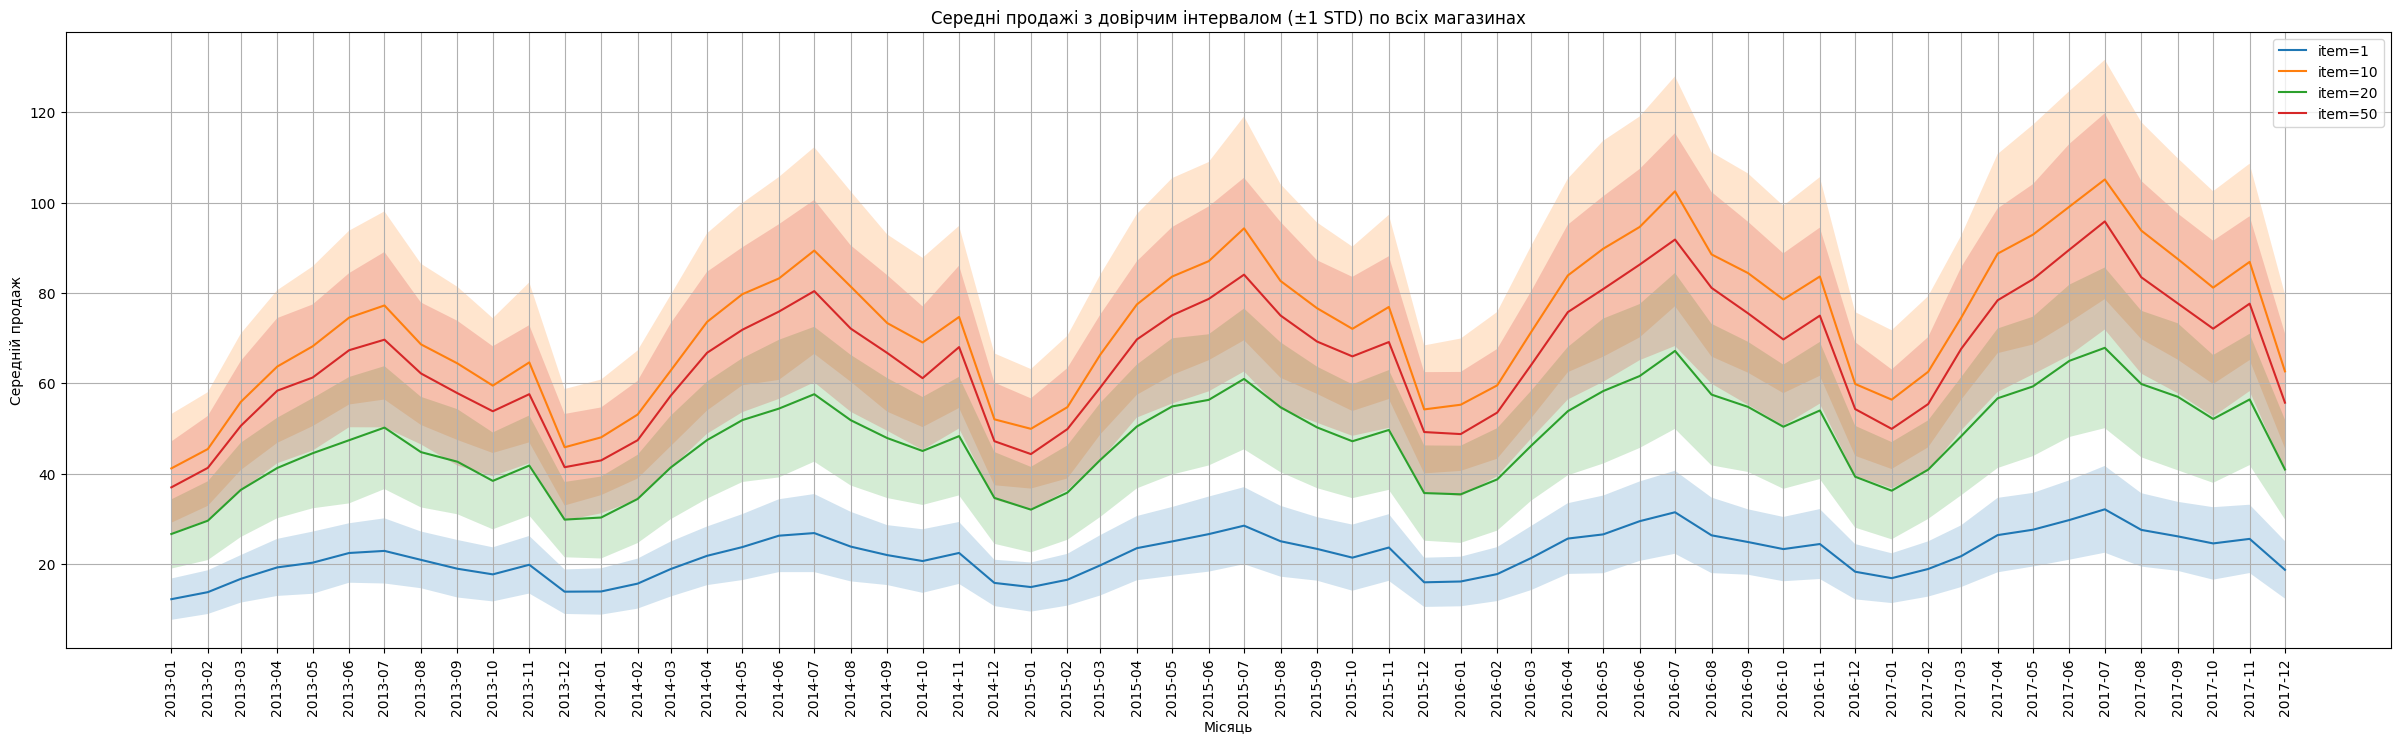

In [ ]:
df_monthly = df.copy()
df_monthly['month'] = df_monthly.index.to_period('M')
df_grouped_monthly = df_monthly.groupby(['month', 'item'])['sales'].agg(['mean', 'std']).reset_index()

df_grouped_monthly['lower'] = df_grouped_monthly['mean'] - df_grouped_monthly['std']
df_grouped_monthly['upper'] = df_grouped_monthly['mean'] + df_grouped_monthly['std']

plt.figure(figsize=(30, 8))
selected_items = [1, 10, 20, 50]

for item in selected_items:
    subset = df_grouped_monthly[df_grouped_monthly['item'] == item]
    plt.plot(subset['month'].dt.to_timestamp(), subset['mean'], label=f"item={item}")
    plt.fill_between(subset['month'].dt.to_timestamp(), subset['lower'], subset['upper'], alpha=0.2)

plt.title("Середні продажі з довірчим інтервалом (±1 STD) по всіх магазинах")
plt.xlabel("Місяць")
plt.ylabel("Середній продаж")
plt.legend()

months_as_dates = [x.to_timestamp() for x in df_grouped_monthly['month'].unique()]
month_labels = [x.strftime('%Y-%m') for x in df_grouped_monthly['month'].unique()]

plt.xticks(ticks=months_as_dates, labels=month_labels, rotation=90)
plt.grid(True)
plt.show()


**Спостереження**:
Агрегація дозволяє легше порівняти загальні тренди продажів різних товарів.

- Графік підтверджує наявність чіткої сезонності продажів. Піки продажів зазвичай спостерігаються літку та ось, а спади - кінець року.

- Бачимо, що піки та спади продажів повторюються майже ідеально кожного року, що свідчить про сильну сезонну компоненту.

- Завдаяки агрегації можемо більш чітко побачити "аномальні" продажі, наприклад в липні та листопаді.

- Бачимо, що грудень-січень завжди спад продажів.

Створемо діаграму для середньго продажу для кожного товару та магазину.

In [ ]:
df_item_average_sales = df.groupby('item')['sales'].mean().reset_index()

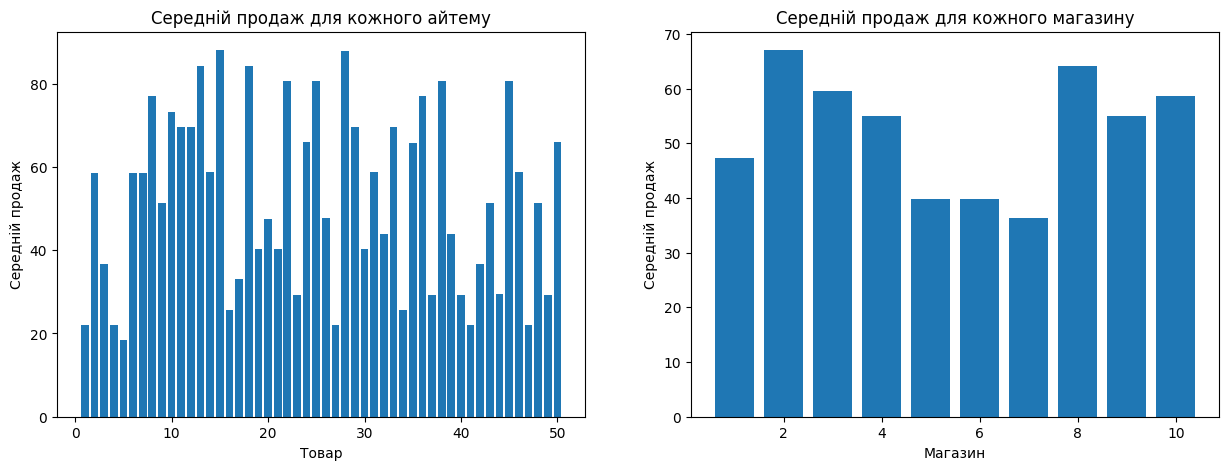

In [ ]:
df_item_avg_sales = df.groupby('item')['sales'].mean().reset_index()
df_store_avg_sales = df.groupby('store')['sales'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].bar(df_item_avg_sales['item'], df_item_avg_sales['sales'])
axes[0].set_title("Середній продаж для кожного айтему")
axes[0].set_xlabel("Товар")
axes[0].set_ylabel("Середній продаж")

axes[1].bar(df_store_avg_sales['store'], df_store_avg_sales['sales'])
axes[1].set_title("Середній продаж для кожного магазину")
axes[1].set_xlabel("Магазин")
axes[1].set_ylabel("Середній продаж")

plt.show()

**Cпостереженя**:

- Розподіл продажів товару не є  рівномірним, деякі товари мають дуже низькі середні продажі, тоді як інші мають значно вищі.

- Можемо сказати, що присутня значна різниця в популярності або попиті на різні товари. Можливо було б доцільно проаналізувати асортимент товарів, щоб визначити, які товари користуються найбільшим попитом, а які - найменшим.

- Для середніх продажів між магазинами можемо говорити, про більш рівномірний розподіл. Магазини мають відносно схожі показники середніх продажів, але є незначні відмінності, які потребують додаткового аналізу.

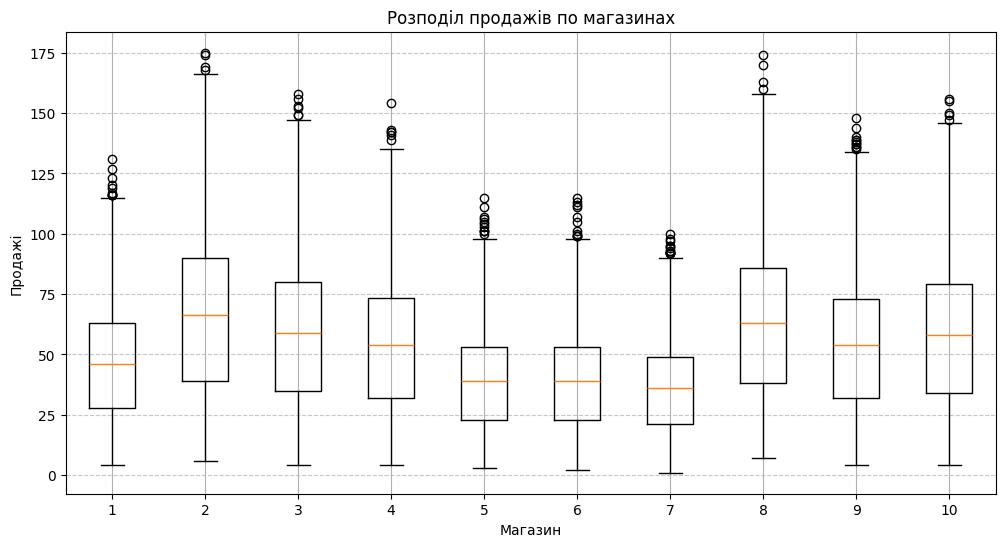

In [ ]:
df_filtered = df[df['item'].isin(selected_items)]
plt.figure(figsize=(12, 6))
stores = sorted(df_filtered["store"].unique())
data_by_store = [df_filtered[df_filtered["store"] == store]["sales"] for store in stores]

plt.boxplot(data_by_store, labels=stores)
plt.title("Розподіл продажів по магазинах")
plt.xlabel("Магазин")
plt.ylabel("Продажі")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.grid(True)
plt.show()

**Спостереження**:

- Магазини 2 та 8 мають значно вищі медіанні продажі та більший  розмах, що свідчить про вищу продуктивність та більшу мінливість продажів. Також магазини мають певну кількість викидів.

- Магазини 1, 5, 6 та 7 мають нижчі медіанні продажі та менший інтерквартильний розмах.

- Магазини 3, 4, 9, 10 мають середні показники.

- У всіх магазинах є викиди, що свідчить про наявність незвичайних значень продажів.


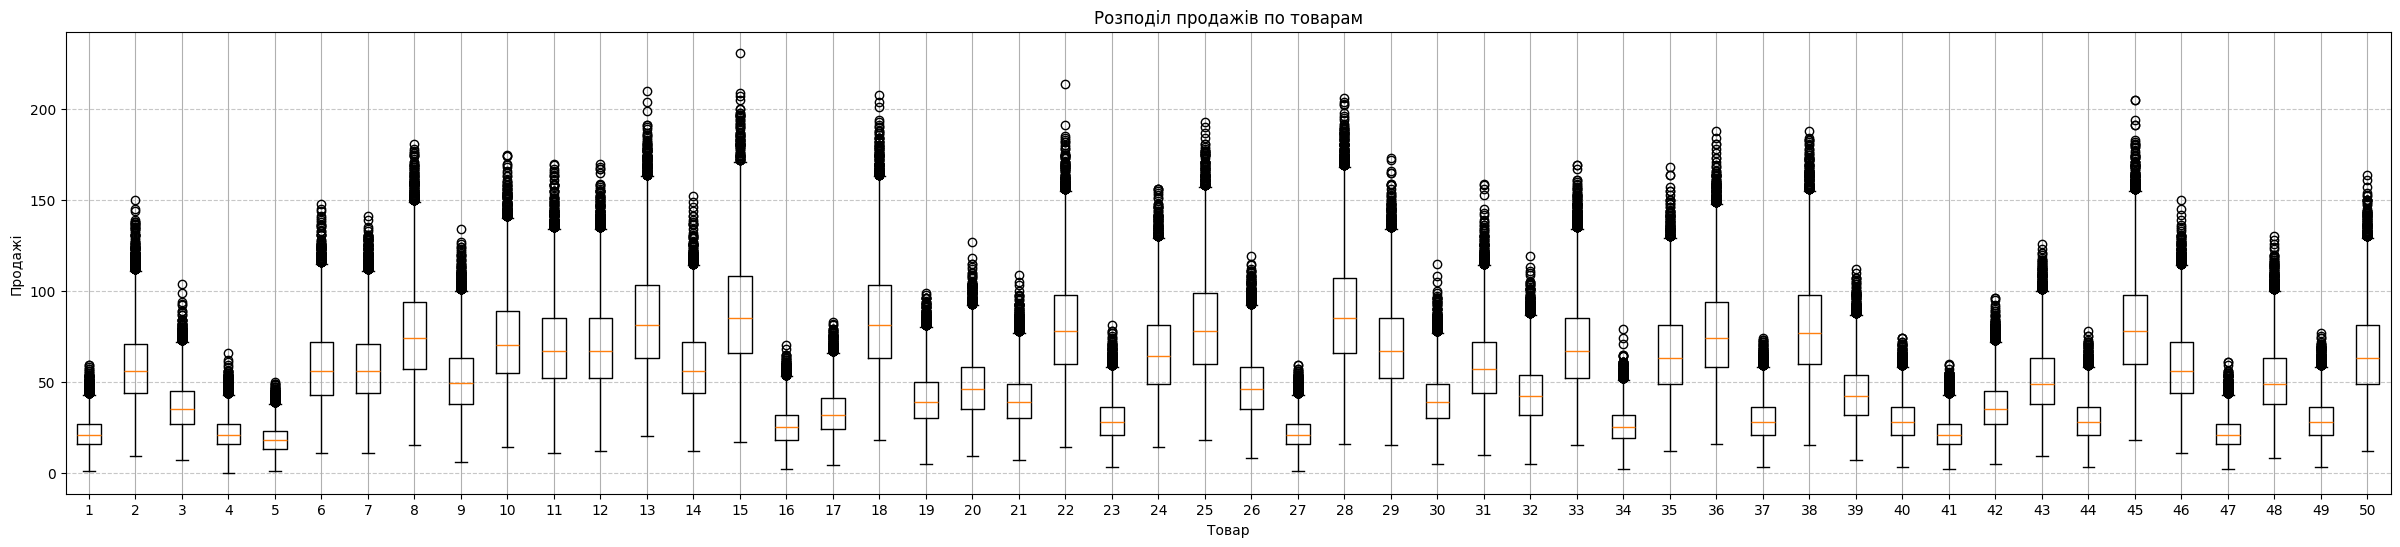

In [ ]:
plt.figure(figsize=(30, 6))
items = sorted(df["item"].unique())
data_by_item = [df[df["item"] == item]["sales"] for item in items]

plt.boxplot(data_by_item, labels=items)
plt.title("Розподіл продажів по товарам")
plt.xlabel("Товар")
plt.ylabel("Продажі")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.grid(True)
plt.show()

**Спостереження**:

- Бачимо велику варіативність між товарами. Деякі товари мають дуже низькі продажі, тоді як інші - значно вищі. Маємо різну популярність товарів.
Медіани також значно відрізняють між товарами.

- Товари, ннаприклад, 8, 13, 15, 18, 25, 18, 36, 45 - мають вищі медіани, та показують кращі продажі. Коли товари 1, 4, 5, 15,27, 41, 47, показуть достатньо низькі медіани, і показують нижчі продажі.

- Також деяк товари мають ширший розмах і у багатьох товарів є викиди, що свідчить про наявність незвичайних значень продажів.

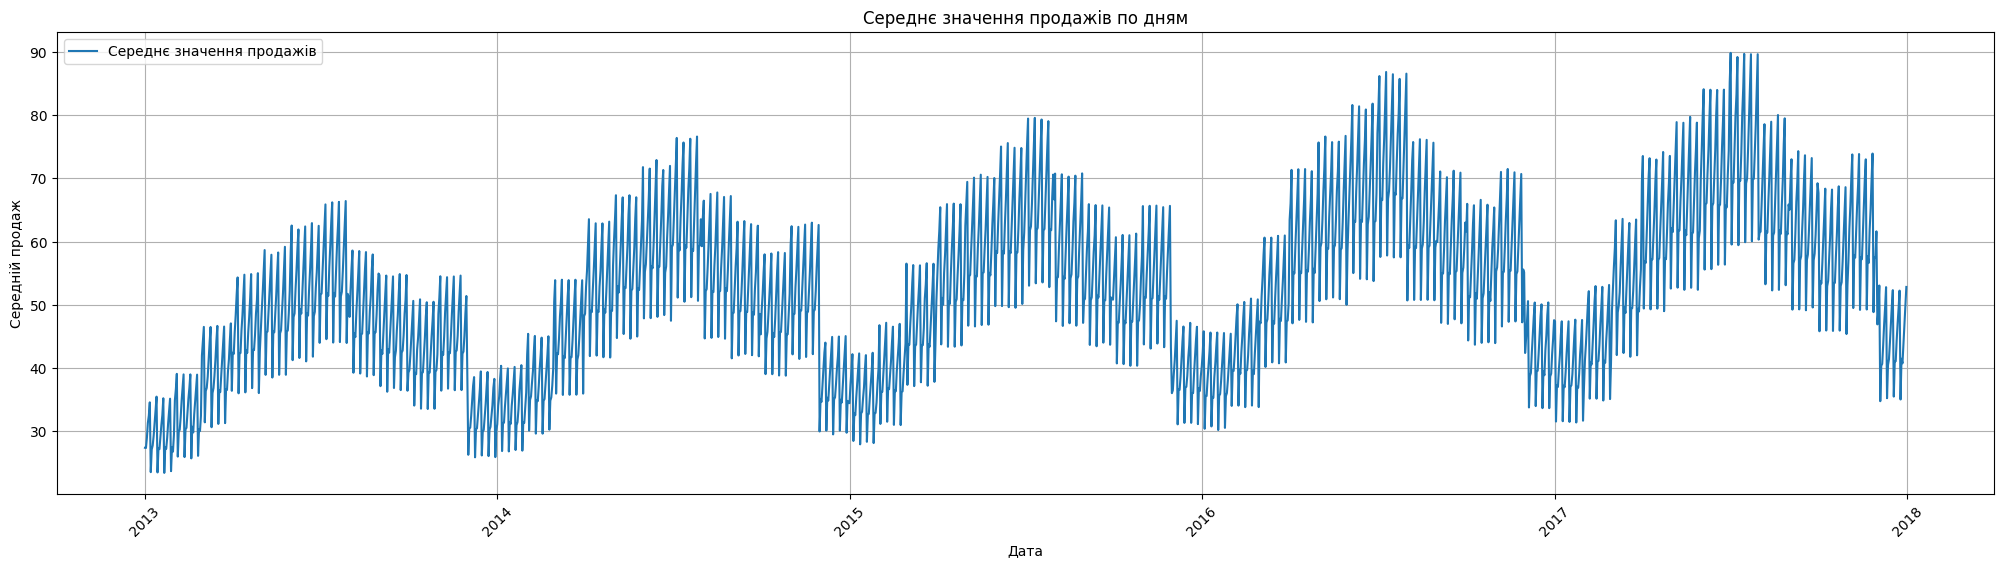

In [ ]:
daily_avg_sales = df.groupby(df.index)["sales"].mean()
plt.figure(figsize=(25, 6))
plt.plot(daily_avg_sales.index, daily_avg_sales, label="Середнє значення продажів", color="tab:blue")

plt.title("Середнє значення продажів по дням")
plt.xlabel("Дата")
plt.ylabel("Середній продаж")
plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()


**Спостереження**:

- Знову бачимо туж саму динаміку подажів, піки в середині року та ближче до кінця, і спади в кінці-початку року.

- Бачимо, що середні родажі мають тенденцію до зростання з часом.

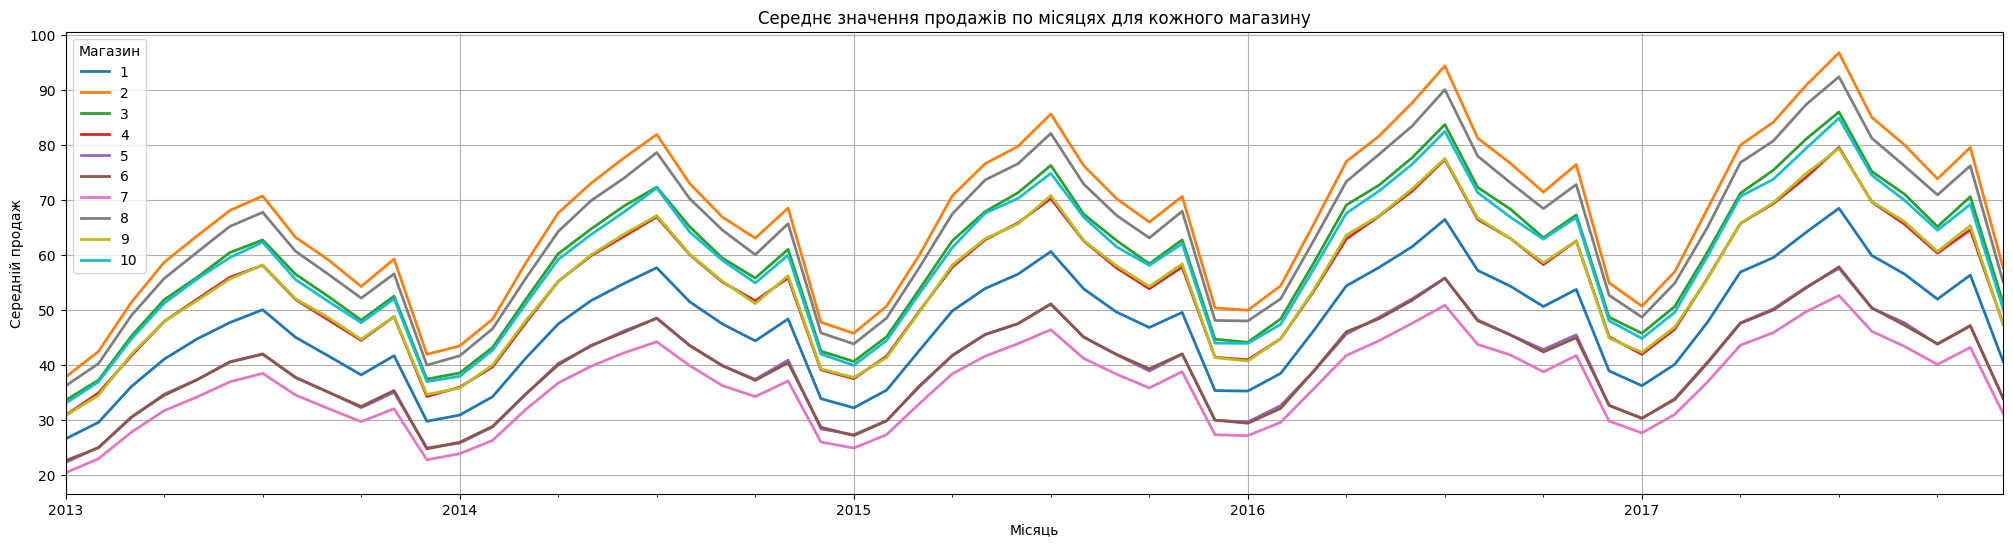

In [ ]:
df_m = df.copy(deep=True)
df_m["month"] = df_m.index.to_period("M")
monthly_avg_sales = df_m.groupby(["month", "store"])["sales"].mean().unstack()

plt.figure(figsize=(25, 6))
monthly_avg_sales.plot(ax=plt.gca(), lw=2)

plt.title("Середнє значення продажів по місяцях для кожного магазину")
plt.xlabel("Місяць")
plt.ylabel("Середній продаж")
plt.legend(title="Магазин")
plt.grid(True)
plt.show()

**Спостереження**:

- Басимо виражену сезонність продажів, яка є схожою для всіх магазинів.Це свідчить про наявність загального сезонного попиту на товари, який впливає на всі магазини.

- Існують значні відмінності в рівнях середніх продажів між магазинами. Магазин 2 показує найвищі продажі, а магазини 7 і 10 - найнижчі.


## Завдання 3

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [ ]:
df_1_1 = df[(df["item"] == 1) & (df["store"] == 1)]
df_1_1.head(3)

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14

In [ ]:
df_additive = df_1_1.copy(deep=True)

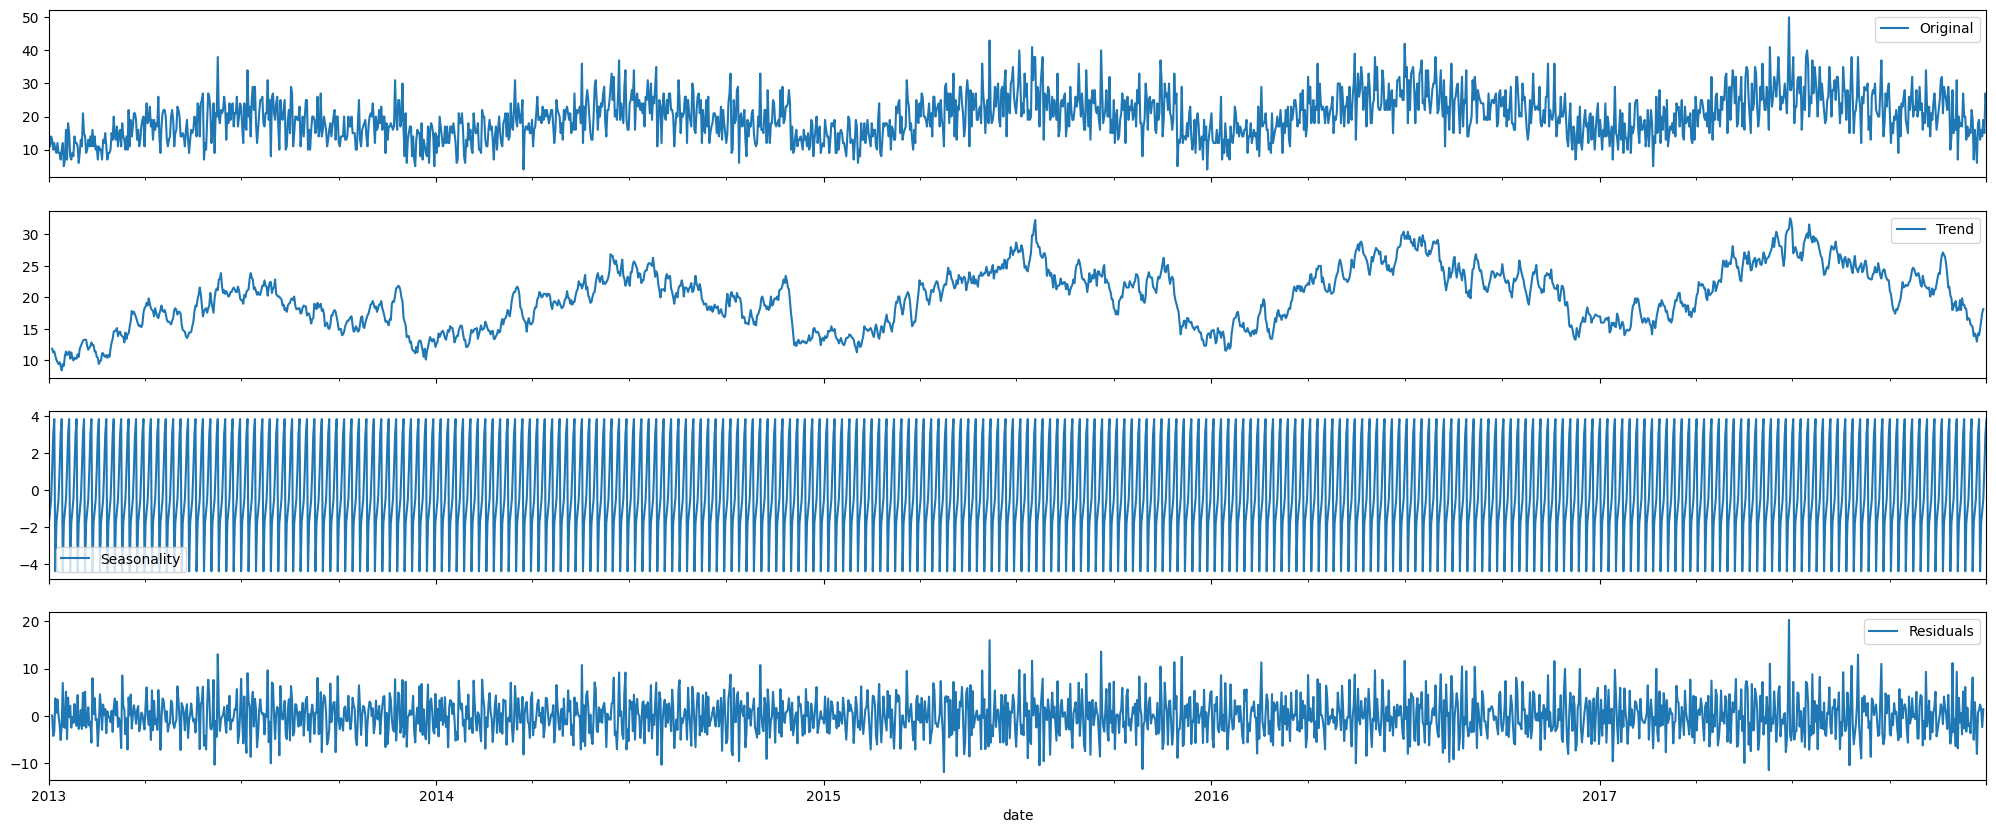

In [ ]:
decomposition = seasonal_decompose(df_additive['sales'], model='additive')

fig, axes = plt.subplots(4, 1, figsize=(25, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], legend=True, label="Original")
decomposition.trend.plot(ax=axes[1], legend=True, label="Trend")
decomposition.seasonal.plot(ax=axes[2], legend=True, label="Seasonality")
decomposition.resid.plot(ax=axes[3], legend=True, label="Residuals")
plt.show()


**Спостереження**:

З побудованої візуалізації бачимо:

- Оригінальний набір данних:спостерігається велика кількість флуктацій, та що графік поступово зростає. Загалом тенденція така, що продажі зростають а потім знижується.

- Тренд: поступово зростає, має декілька піків з різкими змінами.

- Сезонність: бачимо, що сезонність має коливання з висока частототою.

- Залишки: Залишки виглядають стабільними, але періодично з'являються аномальні значення.


*Що могло б допомогти ліпше зрозуміти візуалізації:*

Можливо спробувати згладити тренд, дослідити додатково сезонність, та виявити який період мають цикли сезонності. Таож було б непогано дослідити залишки, адже спостерігаються місцями завеликі значення.


Так як бачимо схожі патерни з періодом в рік, тож доцільноспробувати подивитись на різні роки окремо:

(Для візуалізаціх було взято 2014 - найперший рік у вибірці, та 2017 - останній рік у вибірці.)

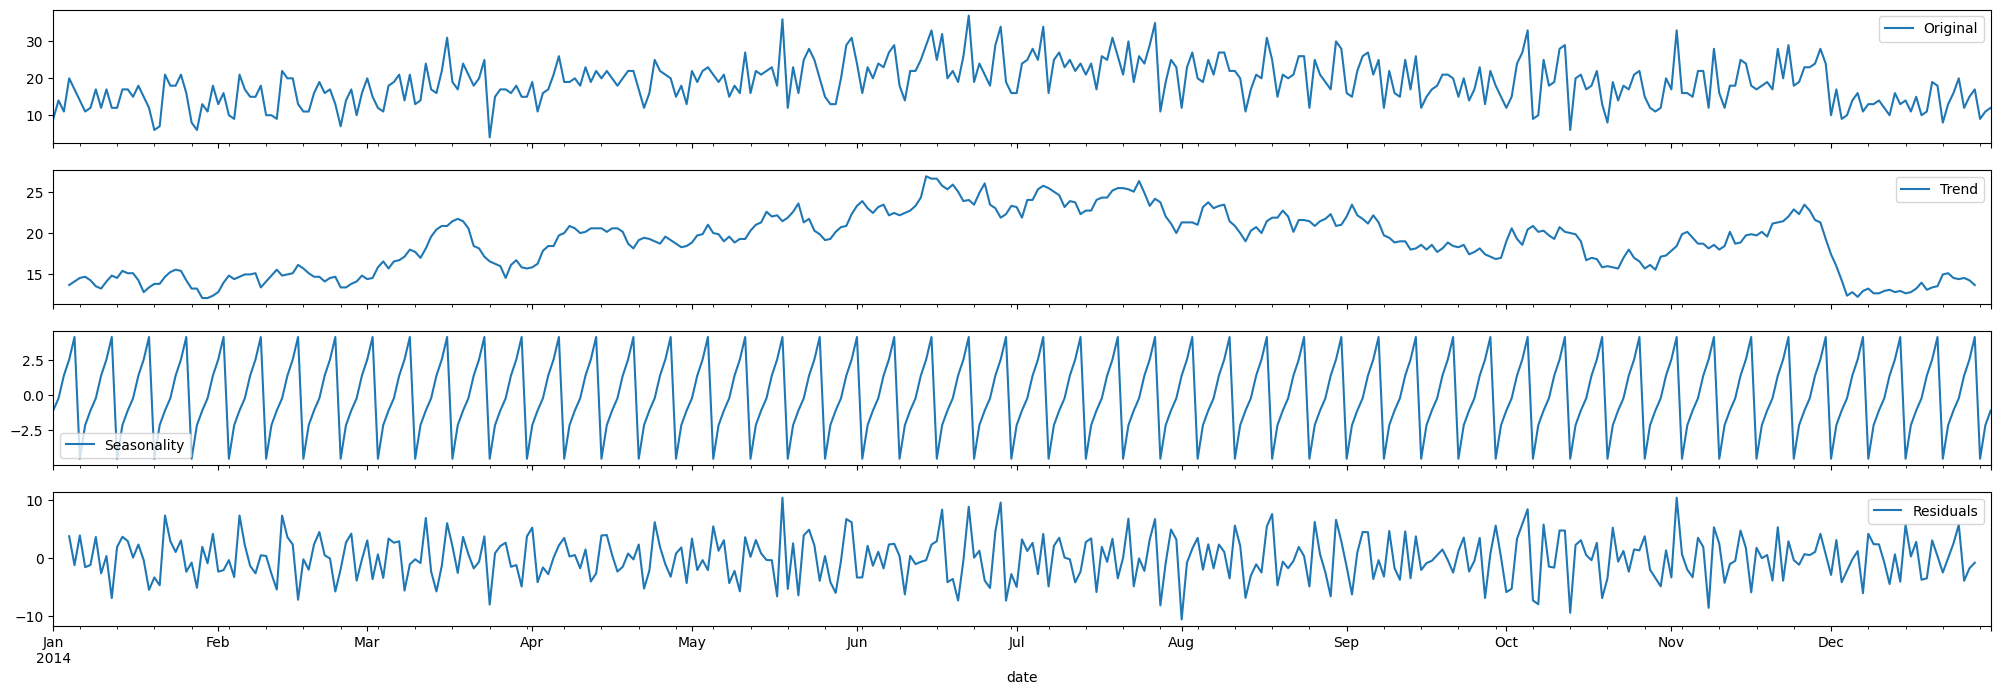

In [ ]:
df_2014 = df_1_1.loc['2014']
decompos_2014 = seasonal_decompose(df_2014['sales'], model='additive')

fig, axes = plt.subplots(4, 1, figsize=(25, 8), sharex=True)

decompos_2014.observed.plot(ax=axes[0], legend=True, label="Original")
decompos_2014.trend.plot(ax=axes[1], legend=True, label="Trend")
decompos_2014.seasonal.plot(ax=axes[2], legend=True, label="Seasonality")
decompos_2014.resid.plot(ax=axes[3], legend=True, label="Residuals")
plt.show()

**Спостереження** для 2014:

- Вцілому помірні коливання продажів, періодичні піки та спади, і вілому продажі протягом року відносно стабільні.

- Бачио зростаючий тренд продажів, особливо в першій половині року, на середині року тренд стабілізується, також бачимо спад тренду на кінці року, різкий спад  на початку грудня, і стабільно відносно низький тренд протягом грудня.

- Бачимо чіткі коливання для сезонності, візуально з періодом приблизно в тиждень.

- Залишки вцілому вигилядають як випадкові, та лежать я в межах +/- 10.

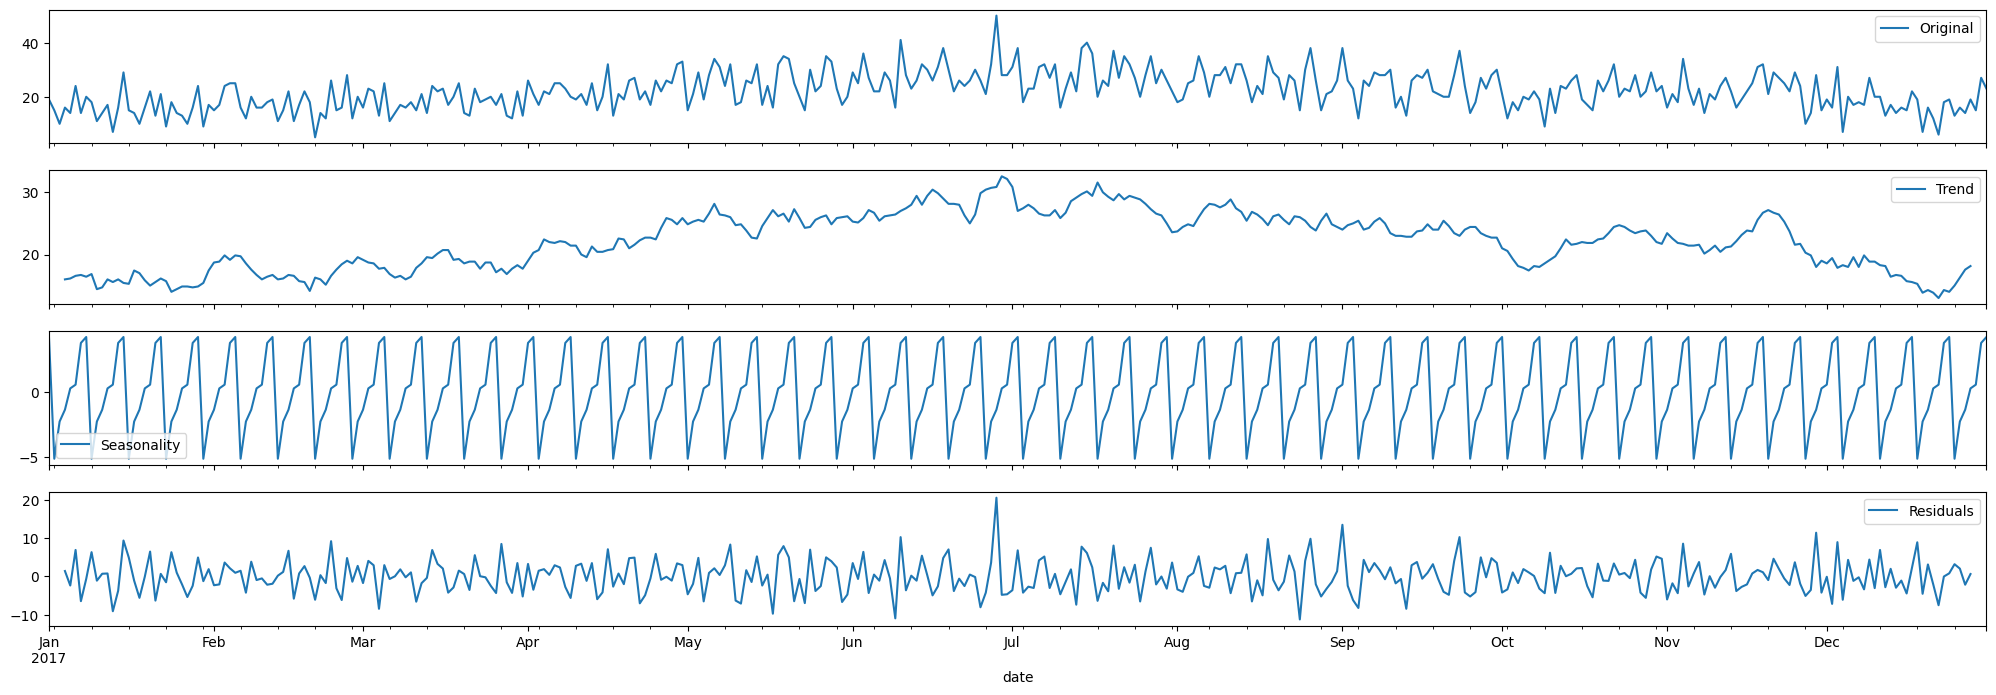

In [ ]:
df_2017 = df_1_1.loc['2017']
decompos_2017 = seasonal_decompose(df_2017['sales'], model='additive')

fig, axes = plt.subplots(4, 1, figsize=(25, 8), sharex=True)

decompos_2017.observed.plot(ax=axes[0], legend=True, label="Original")
decompos_2017.trend.plot(ax=axes[1], legend=True, label="Trend")
decompos_2017.seasonal.plot(ax=axes[2], legend=True, label="Seasonality")
decompos_2017.resid.plot(ax=axes[3], legend=True, label="Residuals")
plt.show()

**Спостереження** для 2017:

- Вцілому помірні коливання продажів, періодичні піки та спади, і вілому продажі протягом року відносно стабільні.

- Також можемо сказати, що в 2017 році спостерігається зростаючий тренд продажів, особливо в першій половині року. Більш стабільний тренд в середні року. Маємо поступове зниження тренду під кінець року.

- Бачимо явно виражену чезонність, з періодом приблизно в тиждень.

- Коливання залишків мають вигляд випадкових, в цілому знаходяться в межах +/- 10, але мають піки, що досягають більших значень.


## Завдання 4

In [ ]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.2/972.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
from darts import TimeSeries
from darts.utils.statistics import plot_pacf, plot_acf, check_seasonality
from darts.metrics import mape
from darts.models import ExponentialSmoothing
from darts.models import NaiveSeasonal, NaiveDrift
from darts.models import AutoARIMA, ARIMA
from darts.models import Prophet
from darts.models import RNNModel
from darts.models import XGBModel

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

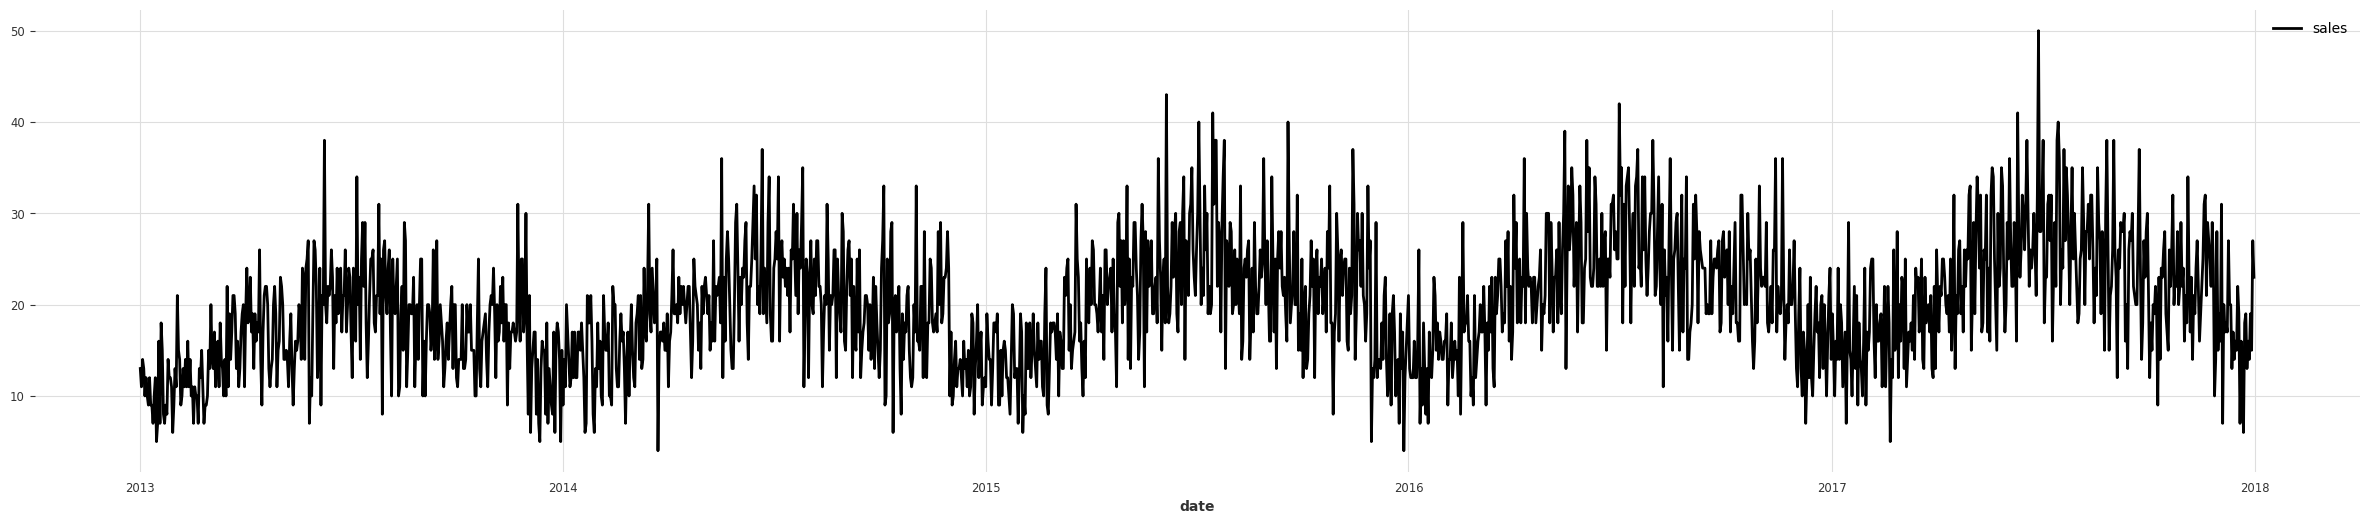

In [ ]:
plt.figure(figsize=(30, 6))
series = TimeSeries.from_series(df_1_1["sales"])
series.plot()
plt.show()

## Завдання 5

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

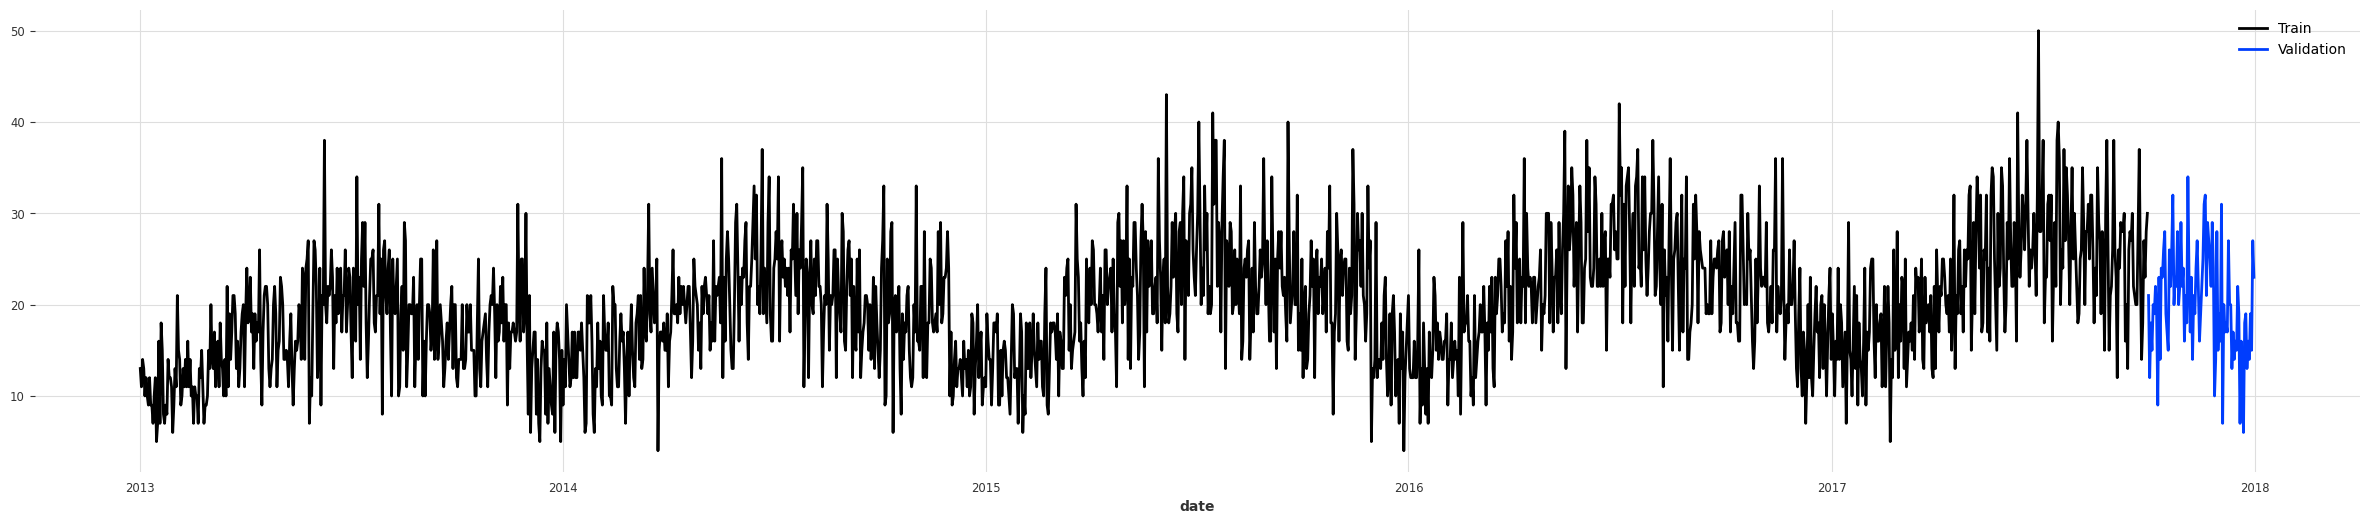

In [ ]:
plt.figure(figsize=(30, 6))
train, validation = series.split_before(pd.Timestamp('2017-10-01'))
train.plot(label="Train")
validation.plot(label="Validation")
plt.show()

## Завдання 6

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

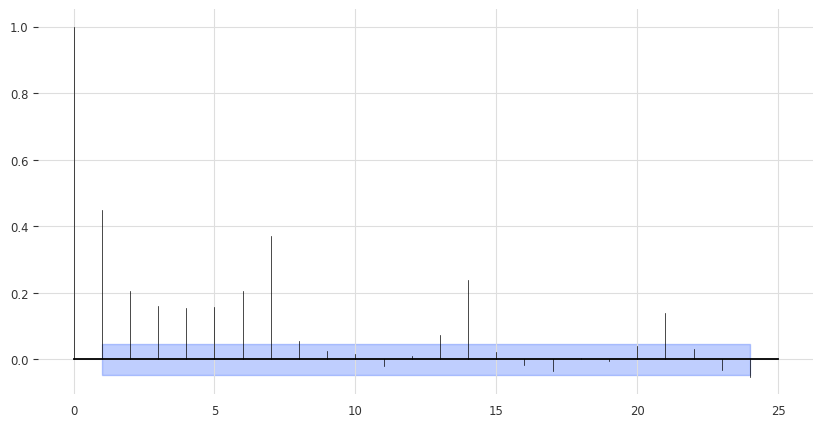

In [ ]:
plot_pacf(series)

**Спостереження**:

Оскільки статистично значущими є лаги, значення яких виходять за межі блакитної області - лаги 1, 2, 3, 4, 5, 6, 7, 14 та 21 є важливими для прогнозування.

Цікавою є припода статистично значущих лагів 14 та 21,  можливо проводиться якась маркетингова кампанія, типу акцій, що збільшує рівень продажів.


## Завдання 7

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


## Завдання 8

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

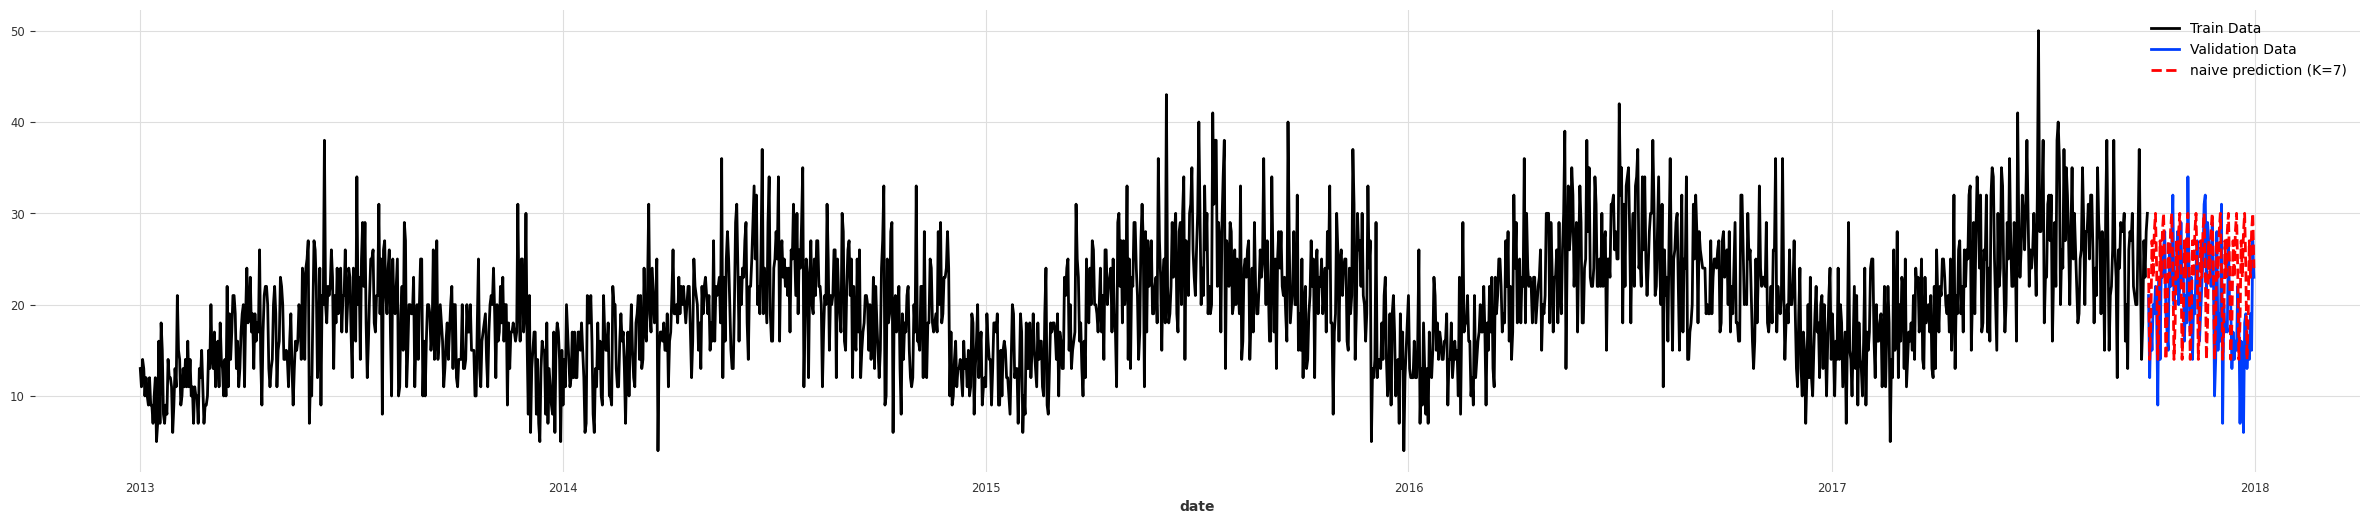

In [ ]:
K=7
naive_seasonal = NaiveSeasonal(K=K)
naive_seasonal.fit(train)
naive_seasonal_forecast = naive_seasonal.predict(len(validation))

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
naive_seasonal_forecast.plot(label=f"naive prediction (K={K})", linestyle="dashed", color='red')

plt.show()

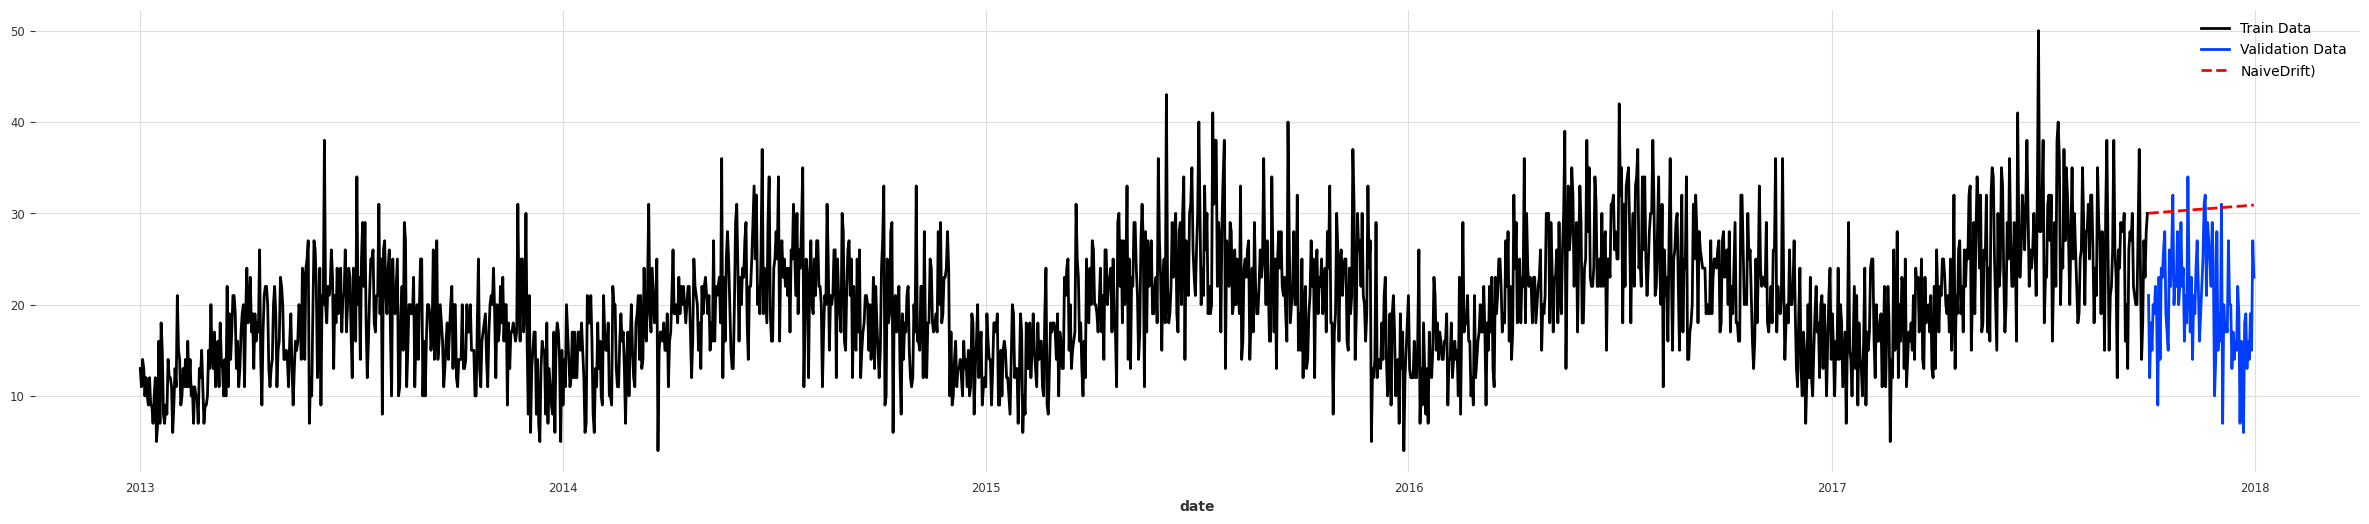

In [ ]:
drift_model = NaiveDrift()
drift_model.fit(train)
forecast_drift = drift_model.predict(len(validation))

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_drift.plot(label="NaiveDrift)", linestyle="dashed", color='red')

plt.show()

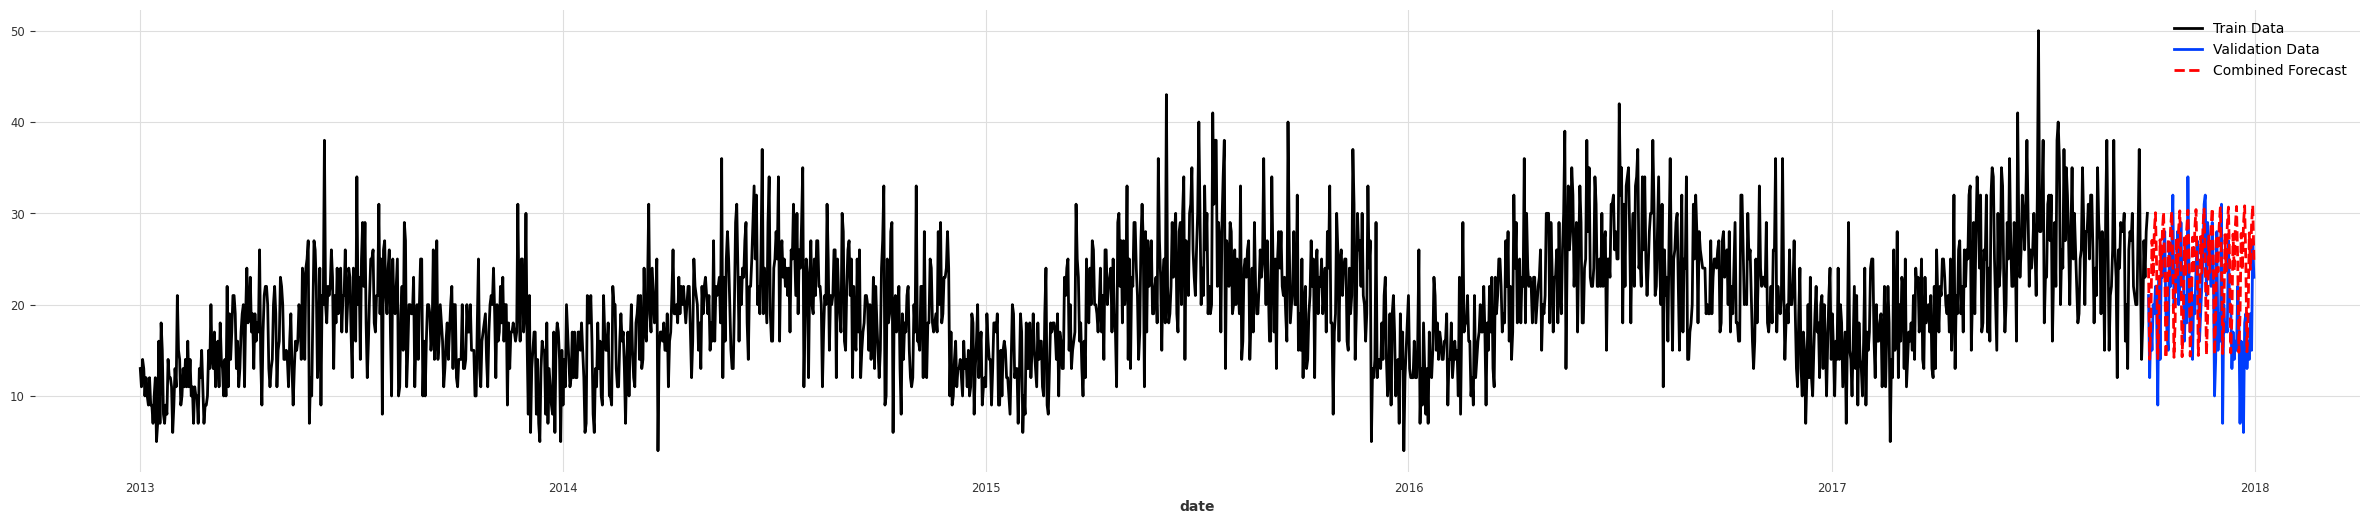

In [ ]:
forecast_combined = (naive_seasonal_forecast + forecast_drift) - train.last_value()

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_combined.plot(label="Combined Forecast", linestyle="dashed", color='red')

plt.legend()
plt.show()

**Спостереження**:

Комбінована моель підхопила загальний тренд та сезонність, яка достатньо виражена - вцілому непогано. Але модель не є дуже точною. Прогнози не точно відповідають фактичним даним та модель не враховує складні патерни в даних.


#### Покращення моделі

При дослідженні сезональності ряду, та побудові автокореляційної фукнції, виявили, що ще лаги 14 та 21 можуть свідчити про циклічність. Тому можемо використати їх для моделювання.

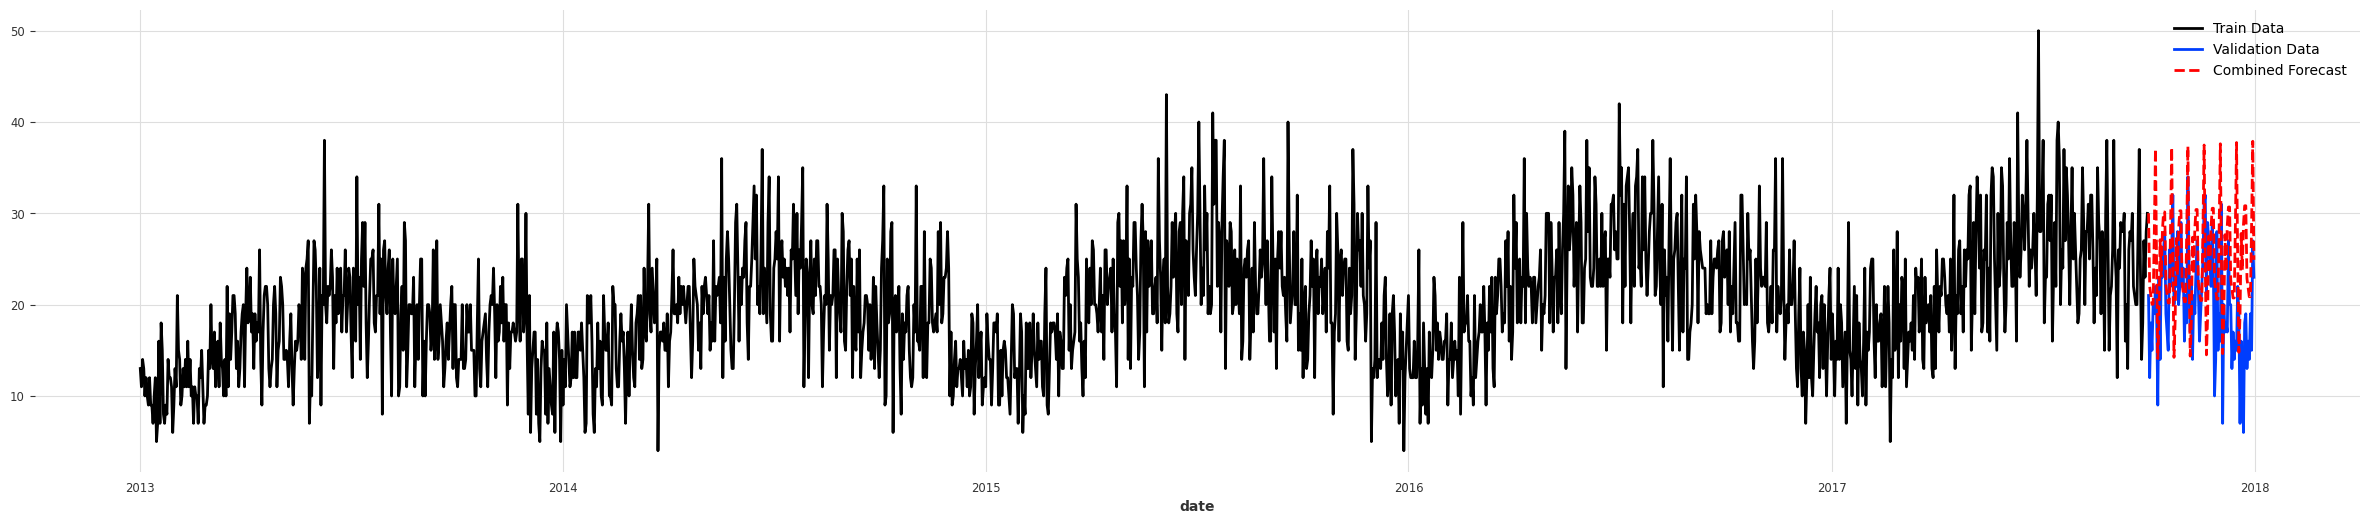

In [ ]:
naive_seasonal_forecast_14 = NaiveSeasonal(K=14).fit(train).predict(len(validation))
forecast_combined_14 = (naive_seasonal_forecast_14 + forecast_drift) - train.last_value()

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_combined_14.plot(label="Combined Forecast", linestyle="dashed", color='red')

plt.legend()
plt.show()

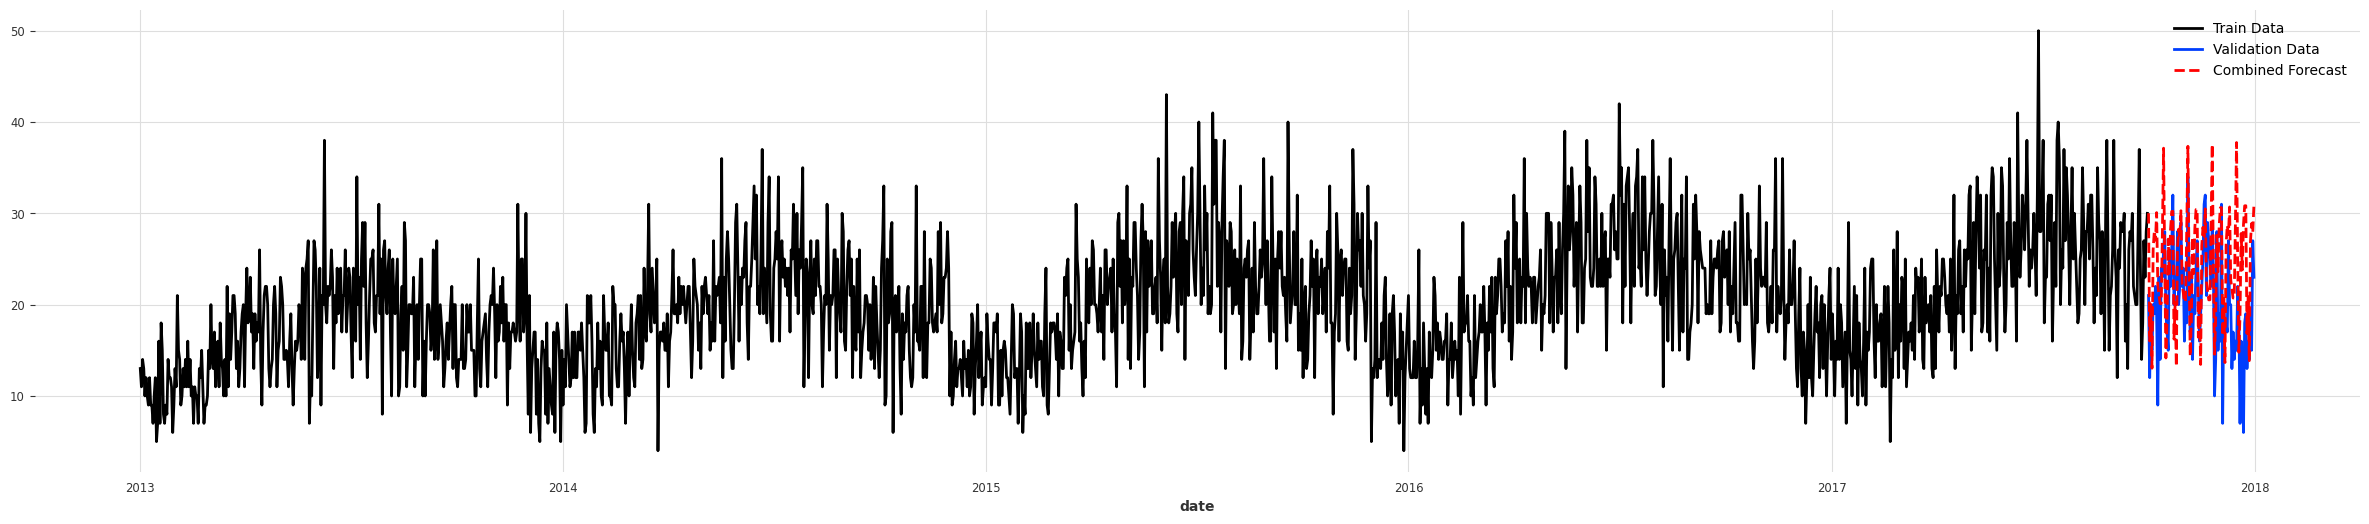

In [ ]:
naive_seasonal_forecast_21 = NaiveSeasonal(K=21).fit(train).predict(len(validation))
forecast_combined_21 = (naive_seasonal_forecast_21 + forecast_drift) - train.last_value()

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_combined_21.plot(label="Combined Forecast", linestyle="dashed", color='red')

plt.legend()
plt.show()

## Завдання 9

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [ ]:
mape_seasonal = mape(validation, naive_seasonal_forecast)
mape_drift = mape(validation, forecast_drift)
mape_combined = mape(validation, forecast_combined)
mape_combined_21 = mape(validation, forecast_combined_21)
mape_combined_14 = mape(validation, forecast_combined_14)

print(f"MAPE для NaiveSeasonal: {mape_seasonal:.2f}")
print(f"MAPE для NaiveDrift: {mape_drift:.2f}")
print(f"MAPE для NaiveSeasonal + NaiveDrift: {mape_combined:.2f}")
print(f"MAPE для NaiveSeasonal_21 + NaiveDrift: {mape_combined_21:.2f}")
print(f"MAPE для NaiveSeasonal_14 + NaiveDrift: {mape_combined_14:.2f}")

MAPE для NaiveSeasonal: 38.17
MAPE для NaiveDrift: 68.74
MAPE для NaiveSeasonal + NaiveDrift: 39.91
MAPE для NaiveSeasonal_21 + NaiveDrift: 39.20
MAPE для NaiveSeasonal_14 + NaiveDrift: 42.18


**Спостереження**:
- *MAPE для NaiveSeasonal* : Модель повторює тренд з періодом в 7 день. Можемо сказати, що сезонність дійсно присутня, але можливо є додаткові фактори, які ця модель не враховує.

- *MAPE для NaiveDrift* : Бажимо, що модель просто екстраполює тренд, значення MAPE також більше за NaiveSeasonal, що може говорити про те, що знайдений тренд моделі не дуже добре відображає реальні зміни у даних.

- *MAPE для NaiveSeasonal + NaiveDrift*: З використанням комбінованої моделі, отримано ліпше значення за модель лище з  NaiveDrift,я кий підхоплює тренд. NaiveSeasonal має трохи краще значення метрики.

- Бачимо, що комбінована модель з K=21 показала найкпращий рещультат серед комбінованих моделей.


## Завдання 10

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

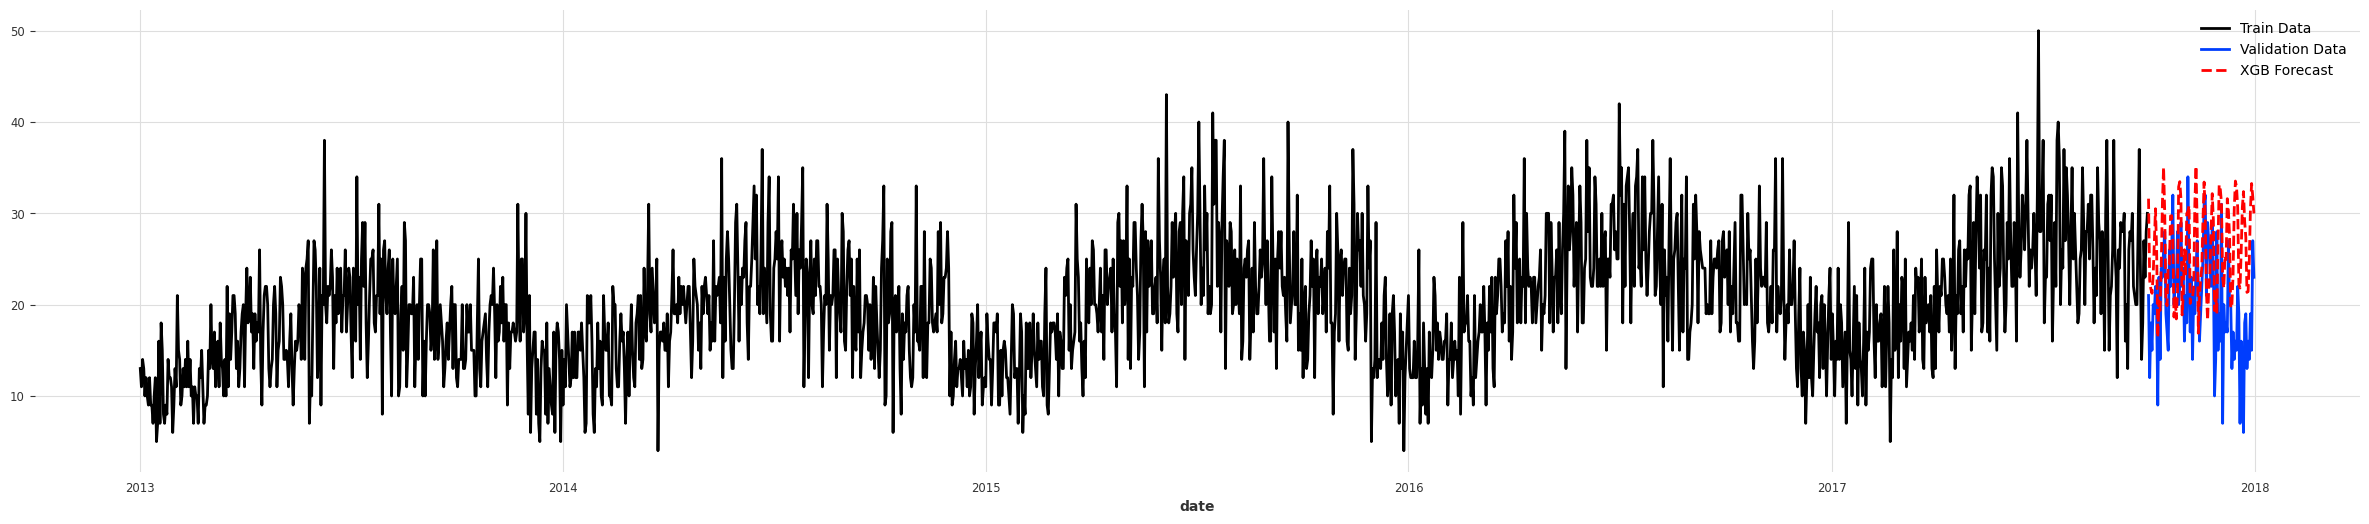

In [ ]:
model = XGBModel(lags=21)
model.fit(train)
forecast_xgb = model.predict(len(validation))

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_xgb.plot(label="XGB Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()


In [ ]:
mape_xgb = mape(validation, forecast_xgb)
print(f"MAPE для XGB: {mape_xgb:.2f}")

MAPE для XGB: 46.75


**Спостереження**:

- Бачимо, що прогнози моделі не точно відповідають фактичним даним,  модель не враховує складні патерни в даних.

- Візуально загальний прогноз відхиляється від основних даних.

- Модель намагається врахувати тренд, але прогнози не точно відтворюють загальну тенденцію зростання або спаду продажів.

Варто спробувати покращити якість моделей за допомогою додаткових ознак.

#### Покращення моделі

Згенеруємо різні ознаки, які можуть бути корисними для виявлення закономірностей

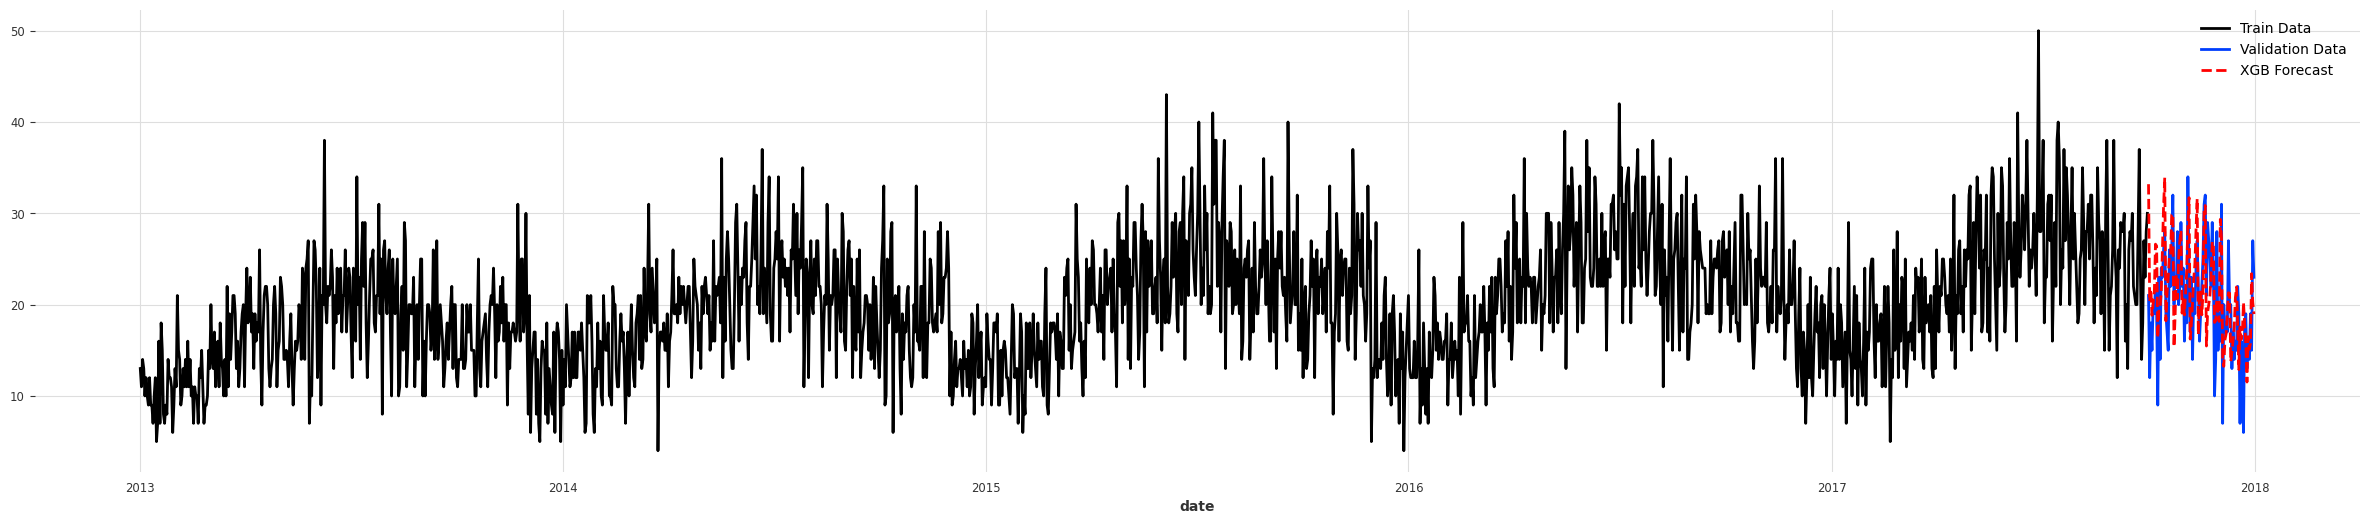

In [ ]:
def create_datetime_features(series):
    time_index = series.time_index
    df = pd.DataFrame(index=time_index)
    df["year"] = time_index.year
    df["month"] = time_index.month
    df["dayofmonth"] = time_index.day
    df["dayofweek"] = time_index.dayofweek
    df["is_weekend"] = (time_index.dayofweek >= 5).astype(int)
    df["quarter"] = time_index.quarter
    df["sin_dayofweek"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["cos_dayofweek"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)

    return TimeSeries.from_times_and_values(time_index, df)

past_covariates = create_datetime_features(series)

xgb_model_cov = XGBModel(lags=21, lags_past_covariates=21, output_chunk_length=7 )
xgb_model_cov.fit(train, past_covariates=past_covariates)
forecast_xgb_cov = xgb_model_cov.predict(len(validation), past_covariates=past_covariates)


plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_xgb_cov.plot(label="XGB Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()

In [ ]:
mape_xgb_cov = mape(validation, forecast_xgb_cov)
print(f"MAPE для XGB_cov: {mape_xgb_cov:.2f}")

MAPE для XGB_cov: 26.41


**Спостереження**:

- Маємо вже кращий прогноз, що підтверджує візуалізація та значення метрики MAPE, отже додавання додаткових ознак суттєво допомогло моделі краще вловити патерни в даних.

- Є періоди, коли прогнози досить близькі до фактичних значень, але є й періоди, коли вони значно відхиляються, отже точність моделі не є ідеальною.

- Модель намагається врахувати сезоннісь, аде не завжди передбачає піки та не завжди точно передбачає амплітуду сезонних коливань.

## Завдання 11

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

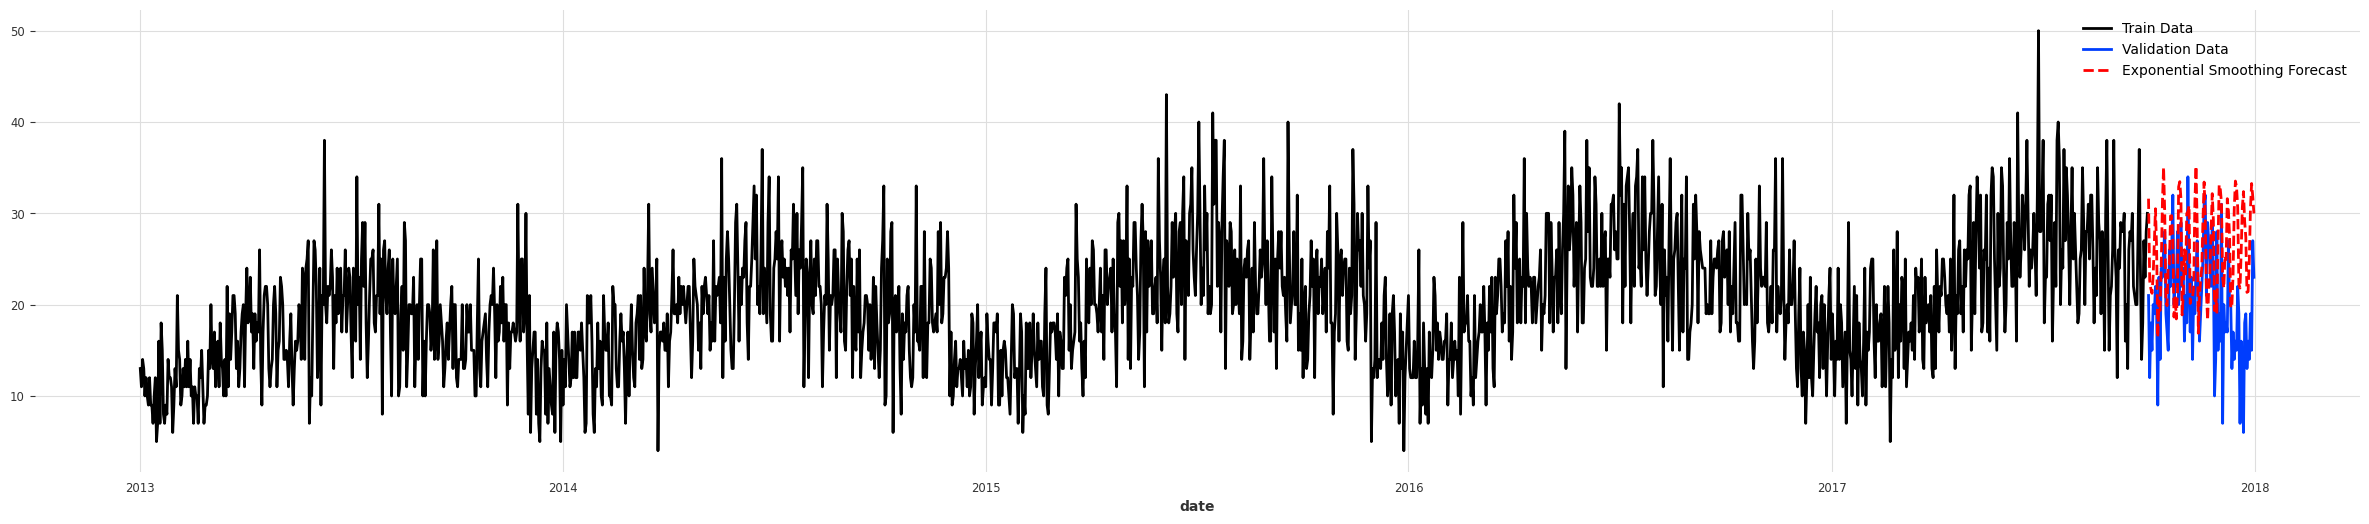

In [ ]:
model_exp = ExponentialSmoothing()
model_exp.fit(train)
forecast_exp = model.predict(len(validation))

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_exp.plot(label="Exponential Smoothing Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()

In [ ]:
mape_exp = mape(validation, forecast_exp)
print(f"MAPE для Exponential Smoothing: {mape_exp:.2f}")

MAPE для Exponential Smoothing: 46.75


**Спостереження**:

- Бачимо, що прогнози не завжди відповідають реальним даним.

- Модель не має не дуже високу точність, часто відхиляються від фактичних значень, особливо у періоди де швидко змінюється кількість продажів.

- Модель погано враховує сезонність, прогноз є достатньо зглажений.

- Модель не відтворює повнітю загальну тенденцію тренду.


## Завдання 12

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

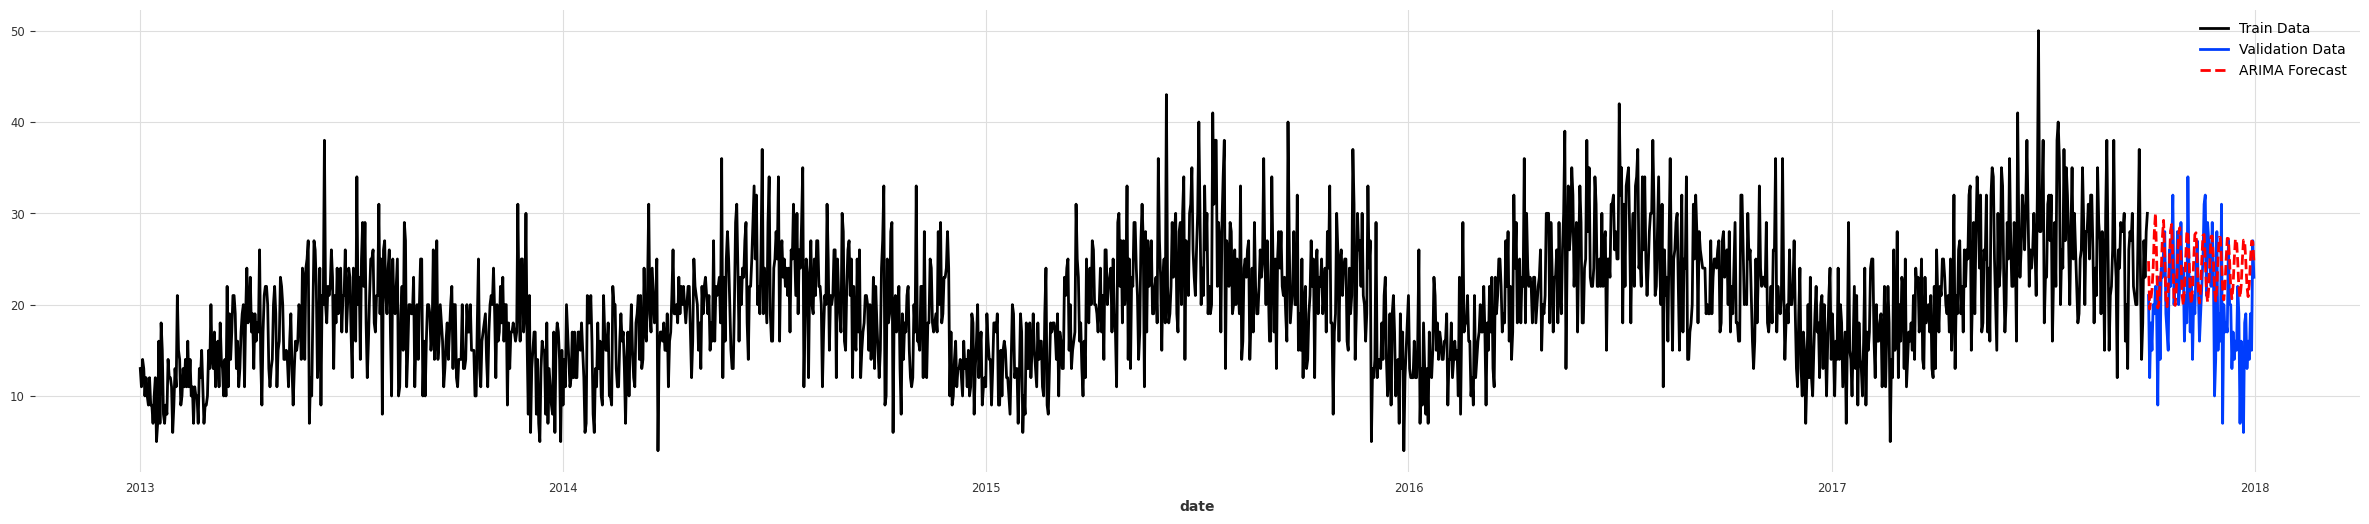

In [ ]:
model_arima = ARIMA(p=21, d=1, q=5)
model_arima.fit(train)

forecast_arima = model_arima.predict(len(validation))

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_arima.plot(label="ARIMA Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()

In [ ]:
mape_arima = mape(validation, forecast_arima)
print(f"MAPE для ARIMA: {mape_arima:.2f}")

MAPE для ARIMA: 37.28


**Спостереження**:

- Загалом модель має кращу точність, чим  деякі попередні моделі, але все ж не високу.

- Модель не враховує сезонність. Піки продажів не співпадають з фактичними даними.

- Тренд модель прогнозує не дуже дообре, прогнози є достатньо зглаженими, скоріше модель покано визначає патерни в тренувальних даних.

- Аплітуда коливань достатньо не точна, фактичні дани мають ширшу амплітуду.


## Завдання 13

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

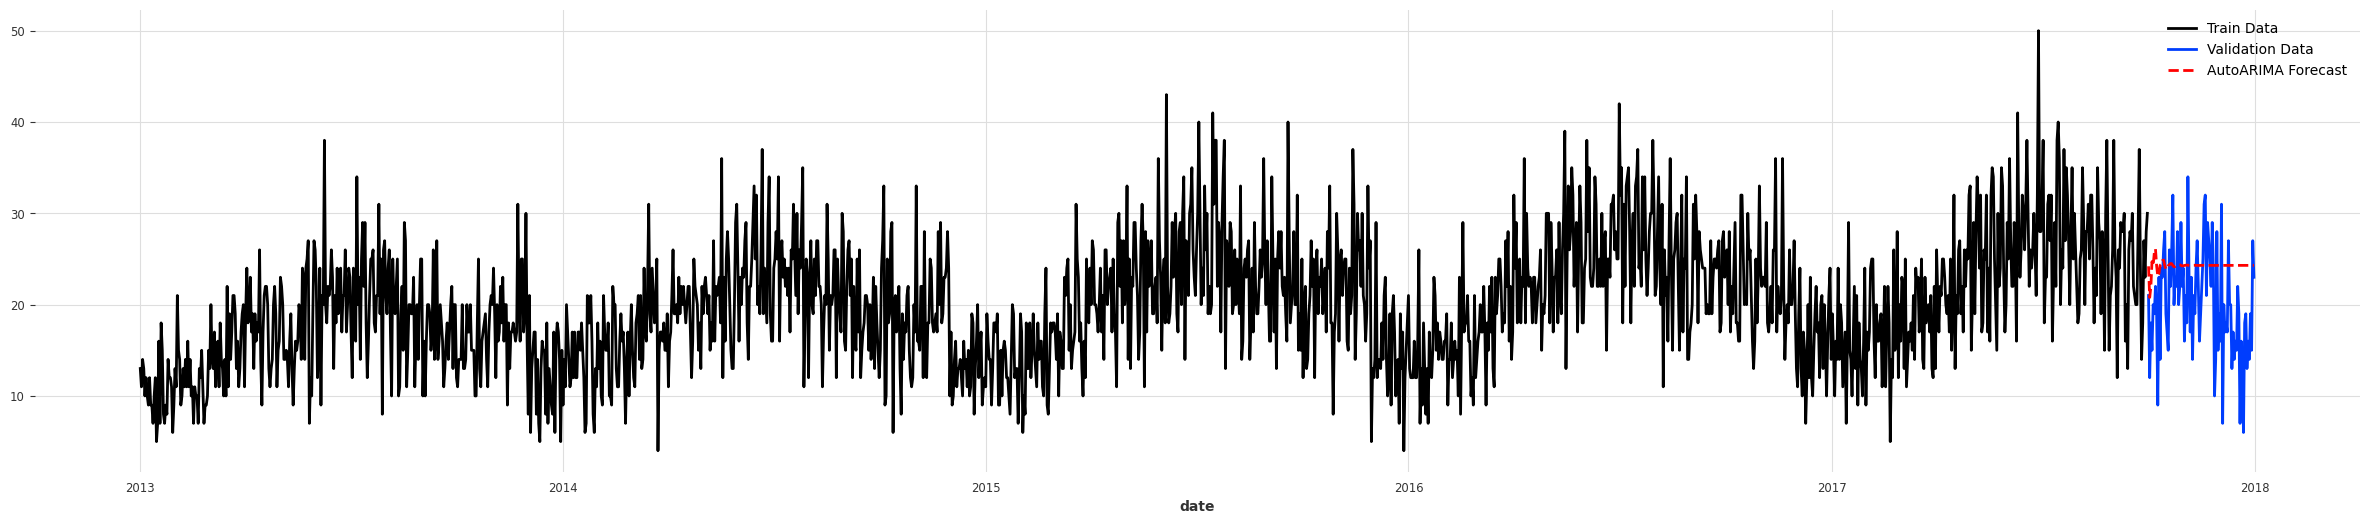

In [ ]:
model_auto_arima = AutoARIMA(start_p=7, max_p=21, start_q=1, max_q=5)
model_auto_arima.fit(train)
forecast_auto_arima = model_auto_arima.predict(len(validation))

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_auto_arima.plot(label="AutoARIMA Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()

In [ ]:
model_auto_arima.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Wed, 05 Mar 2025   AIC                          10591.078
Time:                        09:11:54   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
mape_auto_arima = mape(validation, forecast_auto_arima)
print(f"MAPE для AutoARIMA: {mape_auto_arima:.2f}")

MAPE для AutoARIMA: 39.53


Спостереження:

- Бачимо, що значеня метрики MAPE вказує на невисоку точність моделі. Візуально бачимо, що модель не відтворює реальних даних.

- Приблизно модель визнаячила тренд, але не враховує сезонність.

- Моедль не враховує піків та спадів, що присутні у ряда.

- Прогноз взагалі не відображає мінливості данних, хоча на початку відображав невелкі осциляції, далі приймає вигляд рівної лінії, яка скоріше відображає загальну тенденцію тренду.



## Завдання 14

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv35a9f9/qa8vgng1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv35a9f9/vuoafn9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25547', 'data', 'file=/tmp/tmpbv35a9f9/qa8vgng1.json', 'init=/tmp/tmpbv35a9f9/vuoafn9s.json', 'output', 'file=/tmp/tmpbv35a9f9/prophet_modelq1b5h6tx/prophet_model-20250305091155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:11:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:11:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


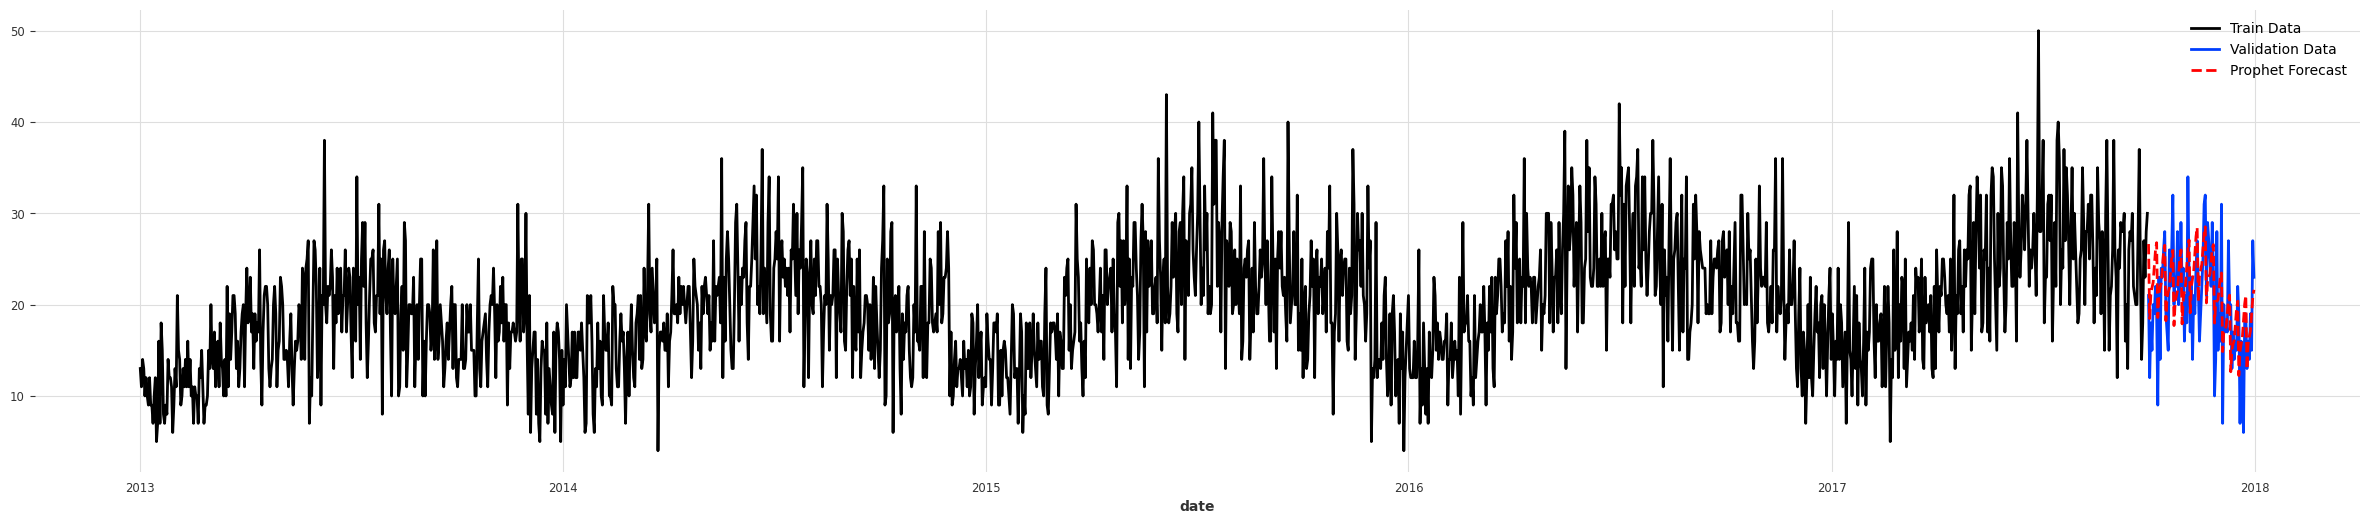

In [ ]:
model_prophet = Prophet()
model_prophet.fit(train)
forecast_prophet = model_prophet.predict(len(validation))

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_prophet.plot(label="Prophet Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()

In [ ]:
mape_prophet = mape(validation, forecast_prophet)
print(f"MAPE для Prophet: {mape_prophet:.2f}")

MAPE для Prophet: 23.80


**Спостреження**:

- Модель показує вже кращі результати метрики якості MAPE.Модель має досить високу точність.

- Бачимо, що показує хорошу відповідність фактичним даним, та прогнози досить точно відображають загальну динаміку продажів.

- Загало прогнози близькі до фактичних значень. Однак, є періоди, коли прогнози відхиляються від фактичних даних.

- Піки та спади прогнозів досить точно збігаються з піками та спадами фактичних даних.Прогнози досить точно відтворюють загальну тенденцію зростання або спаду продажів.


Спробуємо врахувати мультисезонність:

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv35a9f9/fpr6xhmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbv35a9f9/ysk53d9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25470', 'data', 'file=/tmp/tmpbv35a9f9/fpr6xhmg.json', 'init=/tmp/tmpbv35a9f9/ysk53d9y.json', 'output', 'file=/tmp/tmpbv35a9f9/prophet_modelothdl2sp/prophet_model-20250305091155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:11:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:11:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


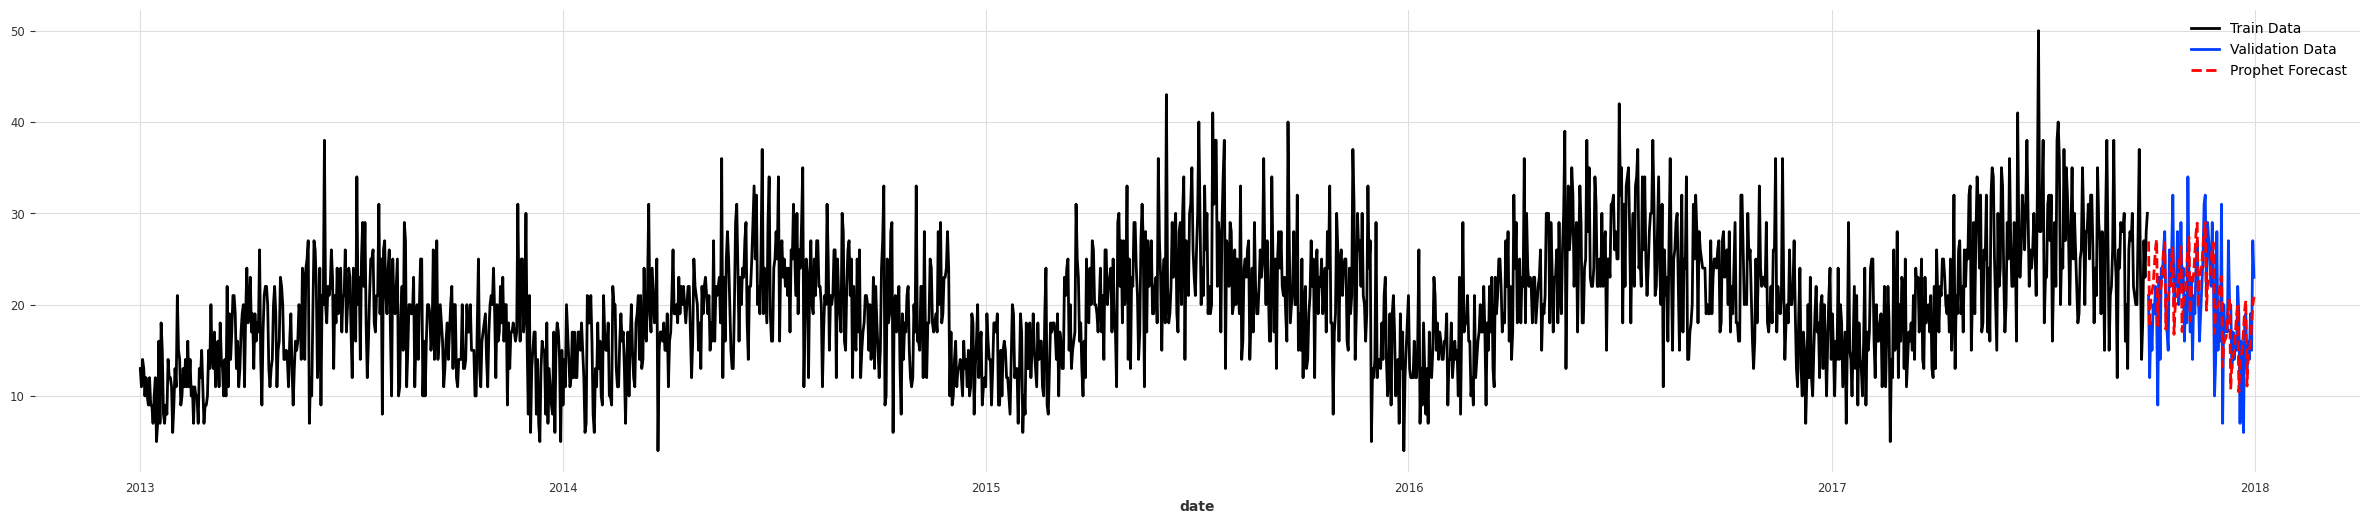

In [ ]:
def create_covariates(series):
    df = series.pd_dataframe()
    df["day_of_week"] = df.index.weekday
    df["day_of_month"] = df.index.day
    df["week_of_year"] = df.index.isocalendar().week
    return TimeSeries.from_dataframe(df, value_cols=["day_of_week", "day_of_month", "week_of_year"])

train_covariates = create_covariates(train)
val_covariates = create_covariates(validation)

model_prophet_seas = Prophet(seasonality_mode="multiplicative")
model_prophet_seas.fit(train, future_covariates=train_covariates)

forecast_prophet_seas = model_prophet_seas.predict(len(validation), future_covariates=val_covariates)

plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_prophet_seas.plot(label="Prophet Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()


In [ ]:
mape_prophet_seas = mape(validation, forecast_prophet_seas)
print(f"MAPE для Prophet: {mape_prophet_seas:.2f}")

MAPE для Prophet: 23.01


**Спостереження**:
Бачимо, що якість моделі покращилась, але не дуже значно.

## Завдання 15

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [ ]:
model_rnn = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model_rnn.fit(train)
forecast_rnn = model_rnn.predict(len(validation))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

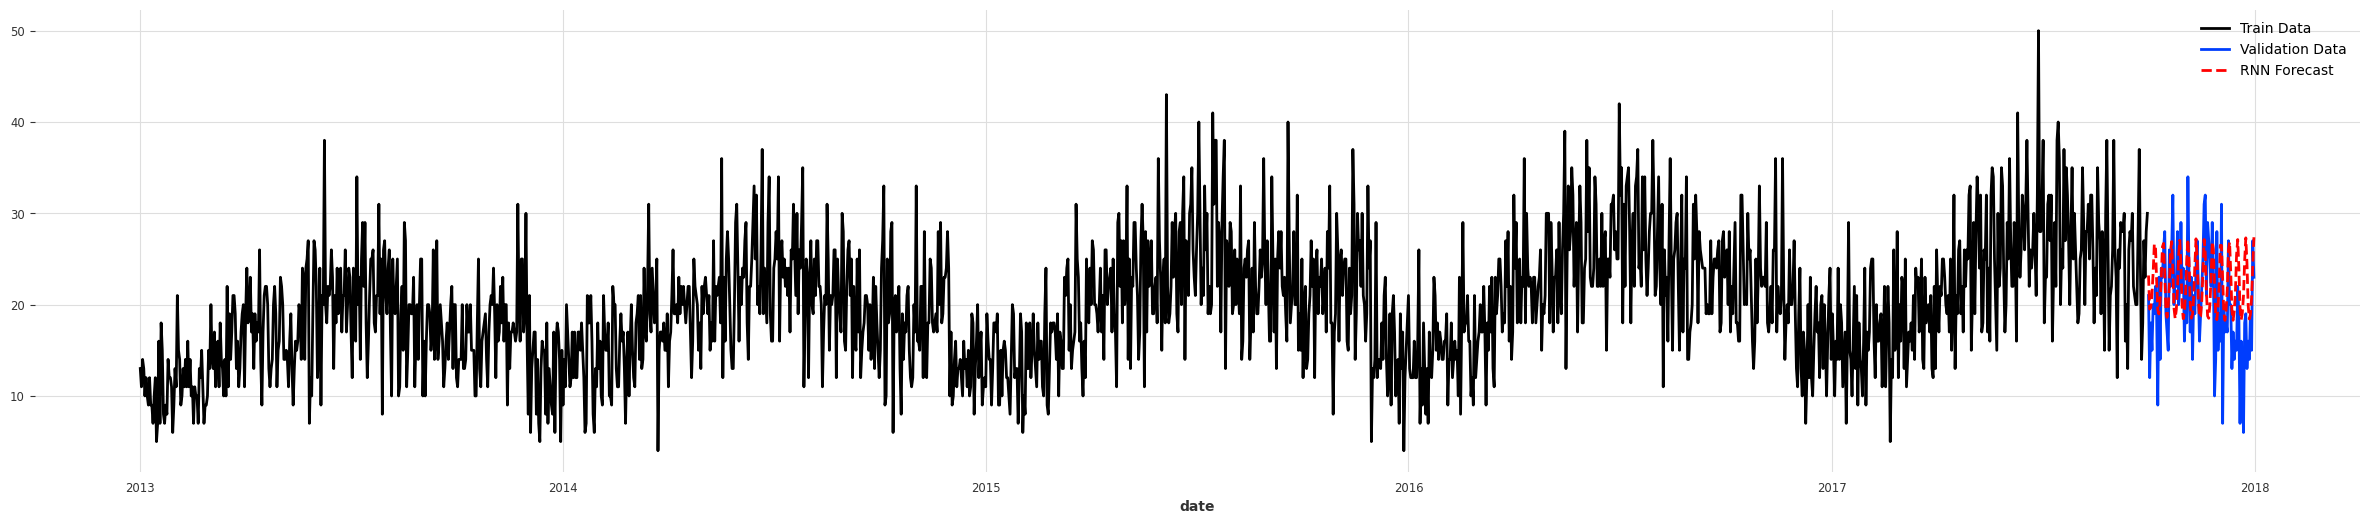

In [ ]:
plt.figure(figsize=(30, 6))
train.plot(label="Train Data")
validation.plot(label="Validation Data")
forecast_rnn.plot(label="RNN Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()

In [ ]:
mape_rnn = mape(validation, forecast_rnn)
print(f"MAPE для Rnn: {mape_rnn:.2f}")

MAPE для Rnn: 30.18


**Спостереження**:

- Модель покахує не дуже хорошу відповідність фактичним даним.

- Прогноз не відтворює сезонності, а скоріше відображає тренд, оскільки спостерігається у лінії погнозів тяжіння до зростання.

- Прогноз не відтворює амплітуди раяду, та є достатньо згладженим та узагаленим.

- Моедль не відтворює періоди спаду або зросту взагалі, в цілому, якщо узагальнити маж монотонне зростання з невеликими осциляціямии.

## Завдання 16

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

Найкраще себе показала модель Prophet, що має майменше значення метрики MAPE.

In [ ]:
model_prophet = Prophet()
model_prophet.fit(train)

hfc_params = {
    "series": series,
    "start": pd.Timestamp("2016-10-01"),
    "forecast_horizon": 30,
    "last_points_only": True,
    "verbose": True,
}

historical_forecasts = model_prophet.historical_forecasts(**hfc_params)

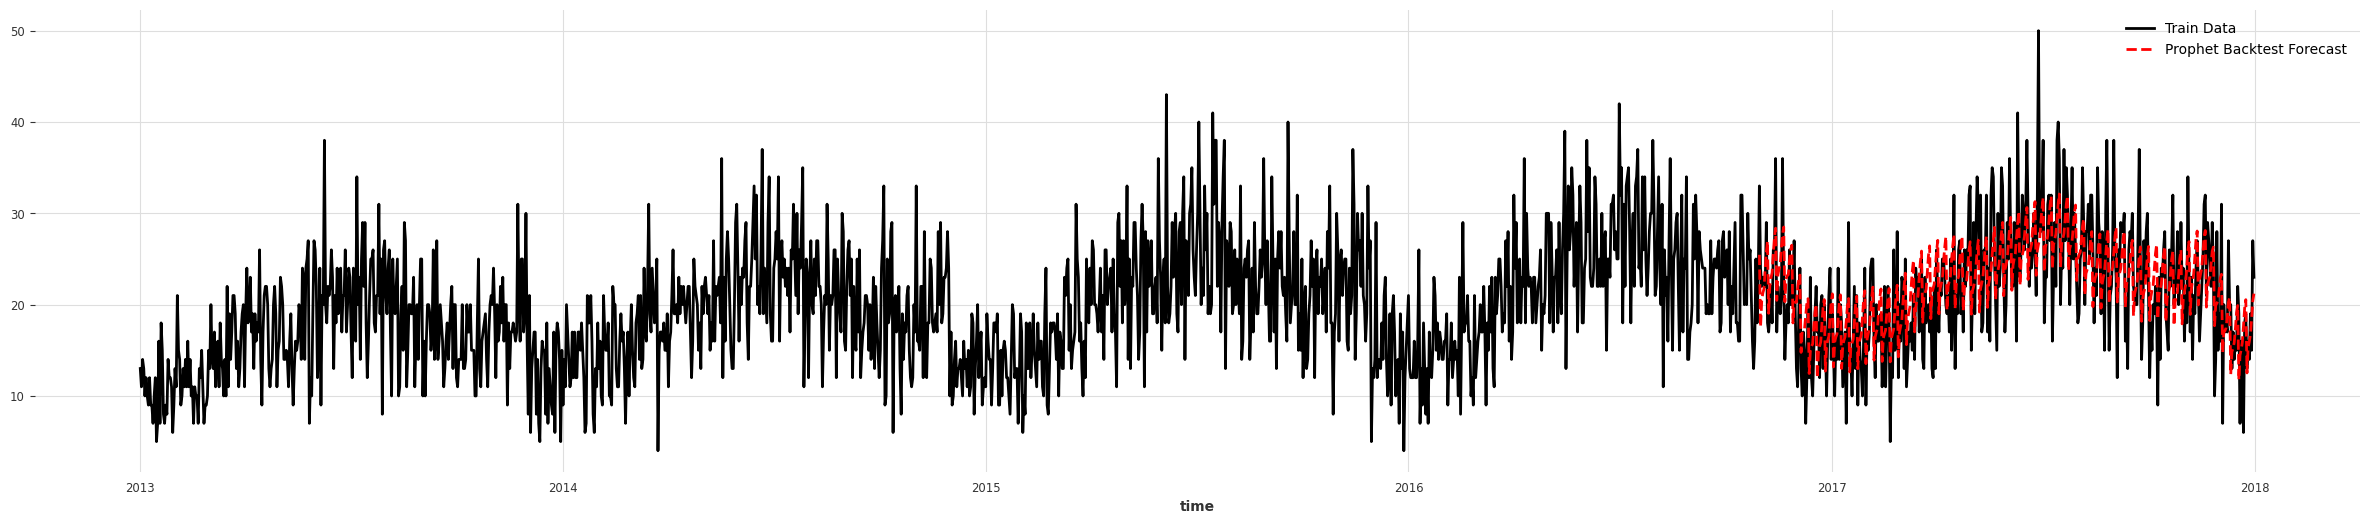

MAPE = 21.78%


In [ ]:
if not isinstance(historical_forecasts, TimeSeries):
    historical_forecasts = TimeSeries.from_series(pd.Series(historical_forecasts))

plt.figure(figsize=(30, 6))
series.plot(label="Train Data")
historical_forecasts.plot(label="Prophet Backtest Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()

mape_prophet_back = mape(series, historical_forecasts)
print(f"MAPE = {mape_prophet_back:.2f}%")

**Спрстереження**:

- Значення метрики MAPE знизилось, отже якість моделі зросла.

- Модель показує дуже хорошу відповідність фактичним даним, прогнози досить точно відображають загальну динаміку продажів.

- Модель має високу точність, і візуально сам прогноз досить близький до фактичних значень, але є і періоди, коли прогнози відхиляються від фактичних даних, особливо в періоди з високою волатильністю, але в цілолому прогноз гарно накладаєтьяс на часовий ряд.

- Модель добре враховує сезонність, піки та спади прогнозів досить точно збігаються з піками та спадами фактичних даних.

- Прогнози досить точно відтворюють загальну тенденцію зростання або спаду продажів, адже модель гарно врахувала тренд даниих.

- Прогнози загалом враховуть мінливість данних, але є менш варантивними в порівнняні з реальнтми даними.

In [ ]:
console = Console()
table = Table(title="Моделі")

table.add_column("Модель", style="cyan", justify="left")
table.add_column("MAPE", style="magenta", justify="center")

table.add_row("NaiveSeasonal", str(mape_seasonal))
table.add_row("NaiveDrift", str(mape_drift))
table.add_row("NaiveSeasonal + NaiveDrift", str(mape_combined))
table.add_row("NaiveSeasonal_21 + NaiveDrift", str(mape_combined_21))
table.add_row("NaiveSeasonal_14 + NaiveDrift", str(mape_combined_14))

table.add_row("XGB", str(mape_xgb))
table.add_row("XGB_cov", str(mape_xgb_cov))

table.add_row("Exponential Smoothing", str(mape_exp))
table.add_row("ARIMA", str(mape_arima))
table.add_row("AutoARIMA", str(mape_auto_arima))

table.add_row("Prophet", str(mape_prophet))
table.add_row("Prophet_seas", str(mape_prophet_seas))
table.add_row("Rnn", str(mape_rnn))

table.add_row("Prophet Backtest", str(mape_prophet_back))

console.print(table)

                        Моделі                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Модель                        ┃        MAPE        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ NaiveSeasonal                 │ 38.174845664426456 │
│ NaiveDrift                    │ 68.74405050496789  │
│ NaiveSeasonal + NaiveDrift    │ 39.90628951234137  │
│ NaiveSeasonal_21 + NaiveDrift │ 39.20495158161071  │
│ NaiveSeasonal_14 + NaiveDrift │ 42.18408252367998  │
│ XGB                           │ 46.745880075594734 │
│ XGB_cov                       │ 26.407201205899568 │
│ Exponential Smoothing         │ 46.745880075594734 │
│ ARIMA                         │ 37.28397524057613  │
│ AutoARIMA                     │ 39.52818304458719  │
│ Prophet                       │ 23.80480380321674  │
│ Prophet_seas                  │ 23.00708308393314  │
│ Rnn                           │ 30.181875631368342 │
│ Prophet Backtest              │ 21.778061190995796 │
└───────────────────────────────┴────────────────────┘

**Висновки**:

- Найкраще себе показала модель Prophet, що має майменше значення метрики MAPE.
Також після бектетингу якість ще зросла. Трохи коаще за зівичайну модель себе показала модель після врахування сезонностей.

- Серед базових моделей найкраще себе показала модель NaiveSeasonal, якість якої є краща  чим у комбінованих моделей.

- Серед комбінованих базових моделей найкращу якість має NaiveSeasonal_21 + NaiveDrift, тоюто комбінована моделл з врахуванням 21-денної сезонності.

- В чистому вигляді XGBoost показав поганий результат. XGBoost з додаванням додаткових ознак продемонструвала значне покразення якості. В цілому бачимо, що XGBoost без додаткових ознак працює гірше за прості наївні методи, але після додавання зовнішніх ознак значно покращує якість прогнозу.

- По результатам вимірювання якості для Exponential Smoothing можемо сказати  результат на XGB, що свідчить про неефективність експоненційного згладжування.

- ARIMA вже трохи краще за наївні моделі, але все ще не ідеально. Коли AutoARIMA гірше, ніж вручну налаштована ARIMA.

- RNN  не перевершила Prophet та XGB, результат близький результат до ARIMA та наївних методів.




## Завдання 17

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Загалом є декілька варіантів. Можна розглянути такий варвант, як усереднити продажі по кожному товару та по кожному магазину, та працювати з часовим рядом яу у випадку розглянутову у домашньому завданні, наче є лише 1 товар та 1 магазин.
Це буде відносно просто реалізувати, має достатньо добре масштабуватися на великий набір даних,  але наврядчи це буде мати значну цінність для магазинів цих товарів, оскільки результат буде дуже узагальнений, та неврахує і не відобразить в прогнозі індивиідуальні оснобливості магазинів та товарів. Хоча такий підхід потенційно зможе врахувати взаємозв’язки між магазинами та товарами.

Можна подумати всторону використання індивідуальних моделей для кожного товару в кожному магазині, отримаємо 500 моделей. Кожну з них буде легко інтерпритувати, але їх достатньо велика кількість.

Компромісом може бути тренування окремої моделі для кожного магазину, так будемо мати лише 10 моделей. Але для такого вибору варто б ще дослідити динаміку продажів товару в різних магазинах. Як бачили з візуалізвцій в перших завданнях, динаміка середніх продажів магазинів є подобніми, але є різниця в рівнях середніх продажів між магазинами. Тож можна розглянути вараіанти групування подвбних за величиною продажів магазинів (та омжна розглянути групування товарів, моделей може бути більше 10, але точно менше 500).

Моделі які б я використовувала: XGBoost або Prophet. Загалом ці моделі показали найркащі результати.
Найбільше схиляюсь до використання XGBoost. Підібравши додаткові парамети для моделі XGBoost, модель може показувати достатньо високу якість. До того ж XGBoost працює значно швидше, ніж Prophet, а так як запропоновано натренувати декілька моделей - це перевага.